In [1]:
#!/usr/bin/env python3
import pandas as pd
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
from glob import glob
from plumbum.cmd import rm
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os.path
import pickle
import datetime
import re

Using TensorFlow backend.


In [2]:
def plotline(data):
    plt.figure()
    plt.plot(data)
    plt.legend()
    plt.show()

def event_count(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    upevents = 0
    downevents = 0
    sameprice = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        if obv > prev_obv:
            upevents += 1
        elif obv < prev_obv:
            downevents += 1
        elif obv == prev_obv:
            sameprice += 1
        prev_obv = obv
    print('=== Event counts on %s ===' % data_name)
    print('upevents')
    print(upevents)
    print('downevents')
    print(downevents)
    print('sameprice')
    print(sameprice)
    print()

def mse(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline on %s ===' % data_name)
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()

In [3]:
def show_summary_statistics():
    #event_count(small_set, 'small')
    train_set = df.iloc[0:num_samples_training]
    dev_set = df.iloc[num_samples_training:num_samples_training+num_samples_dev]
    test_set = df.iloc[num_samples_training+num_samples_dev:]
    event_count(train_set, 'train')
    event_count(dev_set, 'dev')
    event_count(test_set, 'test')
    mse(train_set, 'train')
    mse(dev_set, 'dev')
    mse(test_set, 'test')
#show_summary_statistics()

In [4]:
def preprocess(data):
    values = np.array(data)
    values = values.reshape(-1,1)
    values = values.astype('float32') 
    return values

In [5]:
def plot_losses(model_history, title):
    plt.figure()
    plt.plot(model_history.history['loss'], label='Train')
    plt.plot(model_history.history['val_loss'], label='Dev')
    plt.xlabel('Epochs'); plt.ylabel('Loss (mse)')
    plt.title(title)
    plt.legend(); plt.show()

In [6]:
def plot_predictions(model, X_test, Y_test, Y_prevrawprice, title, inverse=False, scaler=None):
    y_hat = model.predict(X_test)

    if inverse:
        y_hat = inverse_transform(y_hat, Y_prevrawprice, scaler)
        Y_test = inverse_transform(Y_test, Y_prevrawprice, scaler)

    plt.plot(y_hat, label='Predicted')
    plt.plot(Y_test, label='True')
    plt.xlabel('Time'); 

    if inverse:
        plt.ylabel('Price')
    else:
        plt.ylabel('RESCALED Price')

    plt.title(title)
    plt.legend(); plt.show()

In [7]:
def calculate_MSE_RMSE(model, scaler, X_test, Y_test, Y_prevrawprice, model_name):
    y_hat = model.predict(X_test)
    y_hat_inverse = inverse_transform(y_hat, Y_prevrawprice, scaler)
    Y_test_inverse = inverse_transform(Y_test, Y_prevrawprice, scaler)
    mse = mean_squared_error(Y_test_inverse, y_hat_inverse)
    rmse = np.sqrt(mean_squared_error(Y_test_inverse, y_hat_inverse))
    print('%s:' % model_name)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print()

In [8]:
def train_evaluate(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):

    # Train model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                      validation_split=0.05, verbose=verbose, shuffle=False)
    #train_evaluate_showresults(history, model, model_name, 
    #                 X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
    #                 lag, batch_size, epochs, verbose)
    return history

In [9]:
def train_evaluate_showresults(history, model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    # Plot losses, predictions, and calculate MSE and RMSE
    plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
    calculate_MSE_RMSE(model, price_scaler, X_dev, Y_dev, Y_dev_prevrawprice, '%s' % model_name)

In [10]:
def evaluate_test(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    # Plot losses, predictions, and calculate MSE and RMSE
    #plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
    calculate_MSE_RMSE(model, price_scaler, X_test, Y_test, Y_test_prevrawprice, '%s' % model_name)

In [11]:
def initialize_model(X_train, loss, optimizer, num_LSTMs, num_units, dropout, predict_end_of_window):
    
    LSTM_input_shape = [X_train.shape[1], X_train.shape[2]]

    # DEFINE MODEL
    model = Sequential()

    if num_LSTMs == 2:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
              model.add(LSTM(num_units[1], return_sequences=False))
            else:
              model.add(LSTM(num_units[1], return_sequences=True))
        
    if num_LSTMs == 3:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))

            model.add(LSTM(num_units[1], return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
              model.add(LSTM(num_units[2], return_sequences=False))
            else:
              model.add(LSTM(num_units[2], return_sequences=True))

    if predict_end_of_window:
      model.add(Dense(1))
    else:
      model.add(TimeDistributed(Dense(1)))
      
    model.add(Activation('linear'))
    
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [12]:
def split_X(df, temporal_features):
    n_all = df.shape[0]
    n_train = round(n_all * 0.9)
    n_dev   = round(n_all * 0.05)
    n_test  = round(n_all * 0.05)
    print('n_all:  ', n_all)
    print('n_train:', n_train)
    print('n_dev:  ', n_dev)
    print('n_test: ', n_test)
    
    if temporal_features:
        end = 59
    else:
        end = 16

    X_train = df.iloc[:n_train, 1:end].values.astype('float32')
    X_dev   = df.iloc[n_train:n_train+n_dev, 1:end].values.astype('float32')
    X_test  = df.iloc[n_train+n_dev:, 1:end].values.astype('float32')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)

    return X_train, X_dev, X_test

In [13]:
def split_Y(df):
    n_all = df.shape[0]
    n_train = round(n_all * 0.9)
    n_dev   = round(n_all * 0.05)
    n_test  = round(n_all * 0.05)
    Y_train = df.iloc[:n_train, -1:].values.astype('float32')
    Y_dev   = df.iloc[n_train:n_train+n_dev, -1:].values.astype('float32')
    Y_test  = df.iloc[n_train+n_dev:, -1:].values.astype('float32')
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return Y_train, Y_dev, Y_test

In [14]:
def df_to_parquet(df, outfile):
    pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [15]:
def direction_prediction(y_true, y_pred, predict_end_of_window):
    if predict_end_of_window:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / y_true.shape[0]
    else:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / (y_true.shape[0] * y_true.shape[1])
    return prop_correct

In [16]:
def evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window):
    train_loss = history.history['loss'][-1]
    dev_loss   = history.history['val_loss'][-1]
    
    print('Evaluating test loss...')
    test_loss  = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Predicting y_hat_train...')
    y_hat_train = model.predict(X_train)
    print('Predicting y_hat_dev...')
    y_hat_dev   = model.predict(X_dev)
    print('Predicting y_hat_test...')
    y_hat_test  = model.predict(X_test)
    
    train_prop_correct = direction_prediction(Y_train, y_hat_train, predict_end_of_window)
    dev_prop_correct   = direction_prediction(Y_dev, y_hat_dev, predict_end_of_window)
    test_prop_correct  = direction_prediction(Y_test, y_hat_test, predict_end_of_window)
    
    evaluation = {'train_loss': train_loss,
                  'dev_loss': dev_loss,
                  'test_loss': test_loss,
                  'train_prop_correct': train_prop_correct,
                  'dev_prop_correct': dev_prop_correct,
                  'test_prop_correct': test_prop_correct,
                  'y_hat_train': y_hat_train,
                  'y_hat_dev': y_hat_dev,
                  'y_hat_test': y_hat_test}

    return evaluation

In [17]:
def create_sequenced_data(data, window, step):
    sequenced = []
    for minute in range(0, len(data) - window + 1, step):
        chunk = data[minute:minute+window]
        sequenced.append(chunk)
    sequenced = np.array(sequenced)
    return sequenced

In [18]:
def split(df, temporal_features):
    X_train, X_dev, X_test = split_X(df, temporal_features)
    Y_train, Y_dev, Y_test = split_Y(df)
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test 

In [19]:
def load_data(path, day_start=None, day_end=None):

    # Concatenate dataframes
    files = sorted(glob('%s/*.parquet' % path))
    
    if day_start is not None:
        start = day_start
    else:
        start = 0
    if day_end is not None:
        end = day_start
    else:
        end = len(files)
    files = files[start:end]
    
    all_dataframes = []
    for file in files:
        df = pq.read_table(file).to_pandas()
        all_dataframes.append(df)
    df = pd.concat(all_dataframes)
    return df

In [20]:
def create_end_of_window_Y(Y, window, step):
  return np.array([Y[i] for i in range(window-1, len(Y), step)])

In [21]:
def create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test, window_size, step, predict_end_of_window):
    X_train = create_sequenced_data(X_train, window=window_size, step=step)
    X_dev   = create_sequenced_data(X_dev,   window=window_size, step=step)
    X_test  = create_sequenced_data(X_test,  window=window_size, step=step)

    if predict_end_of_window:
      Y_train = create_end_of_window_Y(Y_train, window=window_size, step=step)
      Y_dev   = create_end_of_window_Y(Y_dev,   window=window_size, step=step)
      Y_test  = create_end_of_window_Y(Y_test,  window=window_size, step=step)
    else:
      Y_train = create_sequenced_data(Y_train, window=window_size, step=step)
      Y_dev   = create_sequenced_data(Y_dev,   window=window_size, step=step)
      Y_test  = create_sequenced_data(Y_test,  window=window_size, step=step)
    
    print('Train, dev, test shapes:')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test 

In [22]:
def save_model_history(model, history, model_path):
    # serialize model to JSON
    
    if os.path.exists(model_path):
        suffix = ''.join(re.findall(r'\d+', str(datetime.datetime.now())))
        model_path = model_path + '_' + suffix

    os.makedirs(model_path)
    
    with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
    model_json = model.to_json()   
    with open(model_path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(model_path + '/model.h5')

    print("Saved model and history to:\n%s" % model_path)


In [23]:
def plot_price(df, X_train, X_dev, field):
    X_train_stop = len(X_train)
    X_dev_stop = X_train_stop + len(X_dev)

    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0, X_train_stop), df.iloc[0:X_train_stop][field], 'k')
    plt.plot(np.arange(X_train_stop, X_dev_stop), df.iloc[X_train_stop:X_dev_stop][field], 'r')
    plt.plot(np.arange(X_dev_stop, len(df)), df.iloc[X_dev_stop:len(df)][field], 'g')

In [24]:
def plot_train_dev_losses(history):
    train_loss = history.history['loss']
    dev_loss   = history.history['val_loss']
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(train_loss), 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(dev_loss), 'b')
    
    
    plt.figure(figsize=(20,4))
    plt.plot(train_loss, 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(dev_loss, 'b')
    
    plt.show()

In [25]:
def plot_percent_change(y_pred, y_true, timestep_within_window, minute_start, minute_end, predict_end_of_window):
    
    
    ys=[]
    for i in range(len(y_pred)):
        ys.append(y_pred[i][timestep_within_window])

    original_ys=[]
    for i in range(len(y_true)):
        original_ys.append(y_true[i][timestep_within_window])

        
    ys_orig = np.array(original_ys)
    ys_pred = np.array(ys)
    
    
    OldRange = (ys_pred.max() - ys_pred.min())  
    NewRange = (ys_orig.max() - ys_orig.min())   
    new_ys_pred = (((ys - ys_pred.min()) * NewRange) / OldRange) + ys_orig.min()
    
    
    norm1 = ys_orig / np.linalg.norm(ys_orig)
    norm2 = ys_pred / np.linalg.norm(ys_pred)
    

    plt.figure(figsize=(20,10))
    plt.plot(norm1[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(norm2[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(ys[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(new_ys_pred[minute_start:minute_end], 'r', alpha=0.9)
    
    
    try:
        plt.figure(figsize=(20,10))
        plt.plot(y_true[minute_start:minute_end], 'k', alpha=0.9)
        plt.plot(y_pred[minute_start:minute_end], 'r', alpha=0.9)
    except:
        a = 1

In [30]:
def print_save_events_props(train, dev, test, evaluate, model_name, model_path):
    
    train_event_counts = np.unique(np.sign(train), return_counts=True)
    train_event_prop   = train_event_counts[1] / len(train)
    
    dev_event_counts = np.unique(np.sign(dev), return_counts=True)
    dev_event_prop   = dev_event_counts[1] / len(dev)
    
    test_event_counts = np.unique(np.sign(test), return_counts=True)
    test_event_prop   = test_event_counts[1] / len(test)
    
    print(model_name)
    print('\n========== EVENT COUNTS AND PROPORTIONS ==========')
    print('=== TRAIN ===')
    print('Down, Same, Up:', train_event_counts[1])
    print('Down, Same, Up:', train_event_prop)
    
    print('\n=== DEV ===')
    print('Down, Same, Up:', dev_event_counts[1])
    print('Down, Same, Up:', dev_event_prop)
    
    print('\n=== TEST ===')
    print('Down, Same, Up:', test_event_counts[1])
    print('Down, Same, Up:', test_event_prop)
    
    
    print('\n========== CORRECTION DIRECTION PREDICTIONS ==========')
    print("TRAIN: %f\nDEV:   %f\nTEST:  %f" % (evaluate['train_prop_correct'], 
                                               evaluate['dev_prop_correct'], 
                                               evaluate['test_prop_correct']))
    
    print('\n========== FINAL LOSS ==========')
    print("TRAIN: %s\nDEV:   %s\nTEST:  %s\n" % (evaluate['train_loss'], evaluate['dev_loss'], evaluate['test_loss']))
    
    

In [27]:
# MAIN MODEL ##

# HYPERPARAMETERS
window_size = 30
step = 1
predict_end_of_window = True

batch_size = 1024
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
# num_LSTM = 3
# num_units = [128, 256, 256]
num_LSTM = 2
num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), batch_size, num_epochs, 
                                                                                                                                                loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-30_step-1_predEndWindow-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None



TypeError: split() missing 1 required positional argument: 'temporal_features'

In [27]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, 
                                         dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                      validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592853 samples, validate on 32909 samples
Epoch 1/30
592853/592853 [==============================] - 66s 111us/step - loss: 0.0010 - val_loss: 6.1656e-06
Epoch 2/30
592853/592853 [==============================] - 62s 105us/step - loss: 7.0748e-06 - val_loss: 5.9392e-06
Epoch 3/30
592853/592853 [==============================] - 63s 106us/step - loss: 4.2779e-06 - val_loss: 6.0775e-06
Epoch 4/30
592853/592853 [==============================] - 63s 107us/step - loss: 3.0670e-06 - val_loss: 5.8699e-06
Epoch 5/30
592853/592853 [==============================] - 64s 108us/step - loss: 2.4723e-06 - val_loss: 5.8485e-06
Epoch 6/30
592853/592853 [==============================] - 64s 108us/step - loss: 2.2406e-06 - val_loss: 6.0014e-06
Epoch 7/30
592853/592853 [==============================] - 64s 109us/step - loss: 2.2636e-06 - val_loss: 5.8978e-06
Epoch 8/30
592853/592853 [==============================] - 64s 109us/step - loss: 2.3035e-06 - val_loss: 7.1586e-06
Epoch 9/30
592853

ImportError: `save_weights` requires h5py.

In [39]:
# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

ImportError: `save_weights` requires h5py.

In [46]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating testlLoss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-30_step-1_predEndWindow-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [142066 299707 151080]
Down, Same, Up: [0.23963107 0.50553341 0.25483552]

=== DEV ===
Down, Same, Up: [15019  2434 15456]
Down, Same, Up: [0.45637971 0.07396153 0.46965876]

=== TEST ===
Down, Same, Up: [14874  2809 15226]
Down, Same, Up: [0.45197362 0.08535659 0.46266979]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.246388
DEV:   0.460208
TEST:  0.457717

========== FINAL LOSS ==========
TRAIN: 1.6946025963724492e-06
DEV:   6.255371851601668e-06
TEST:  1.6946025963724492e-06



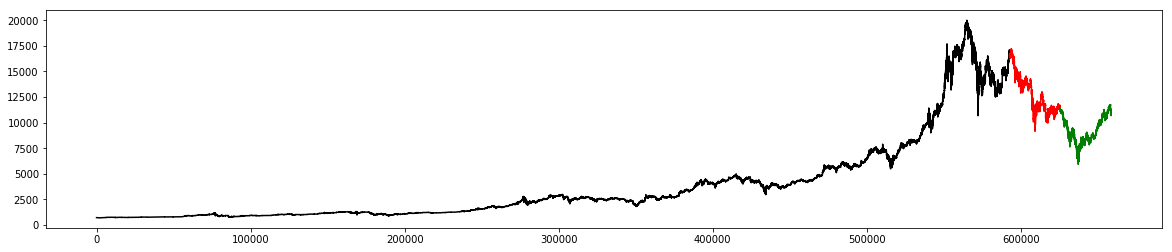

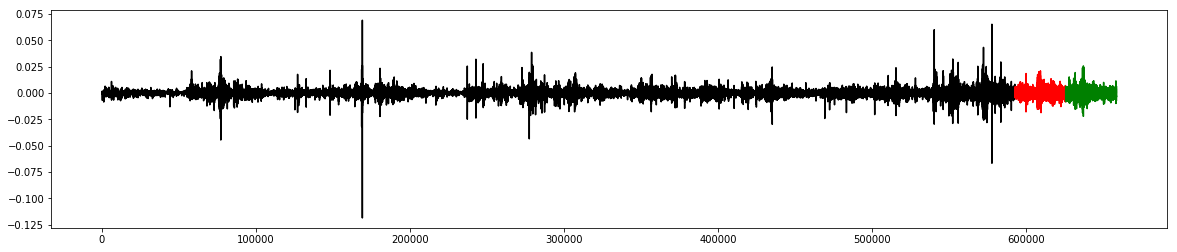

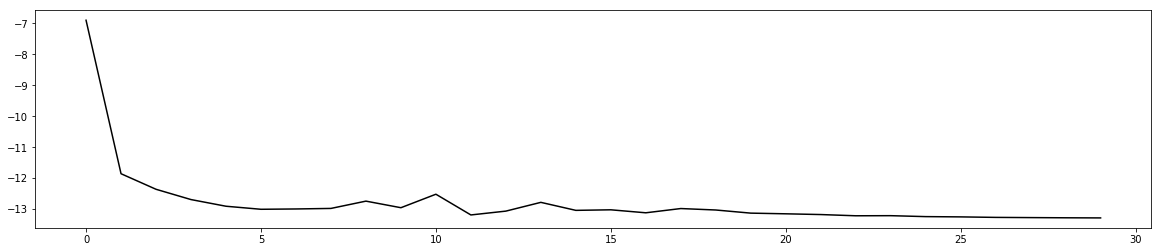

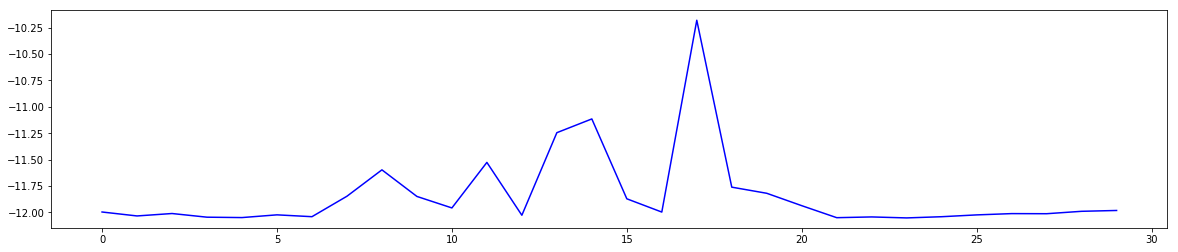

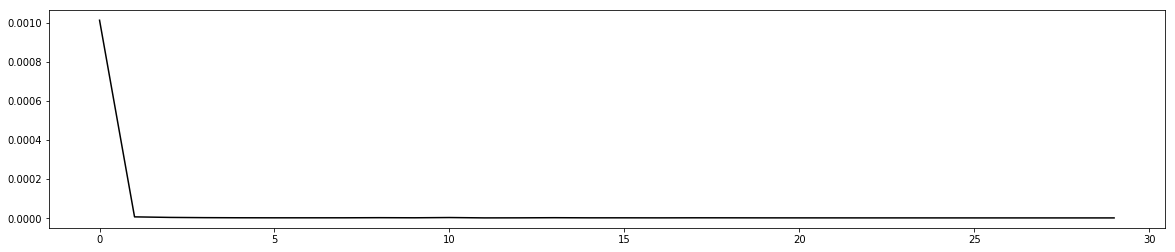

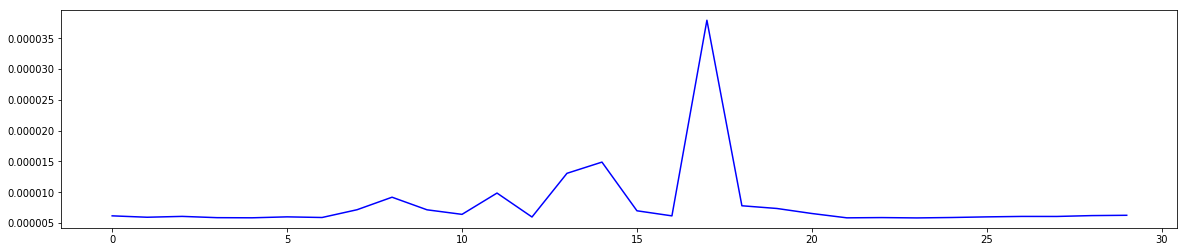

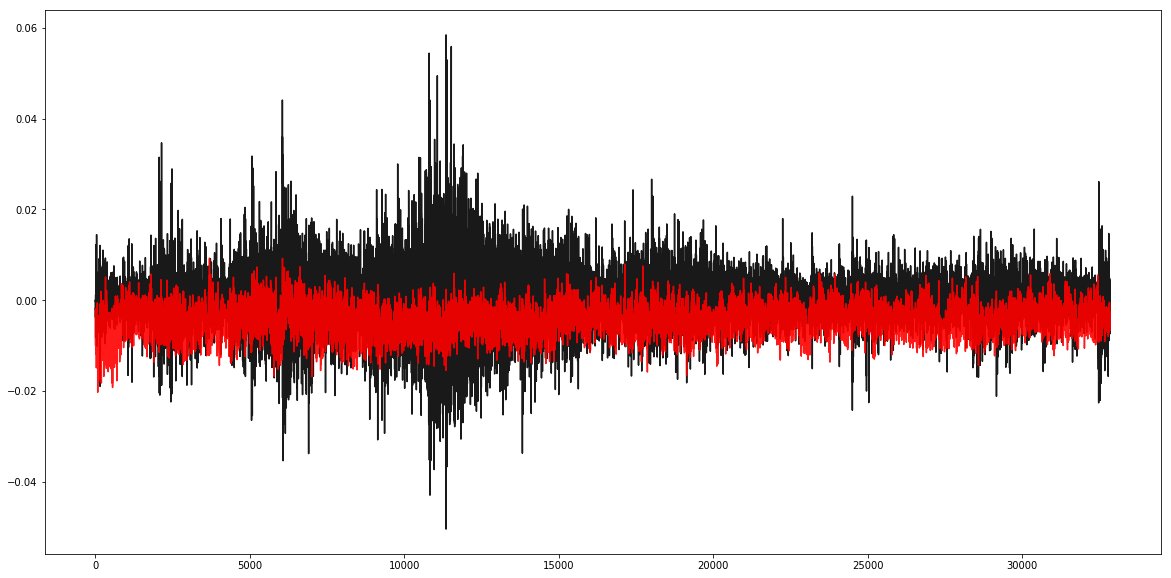

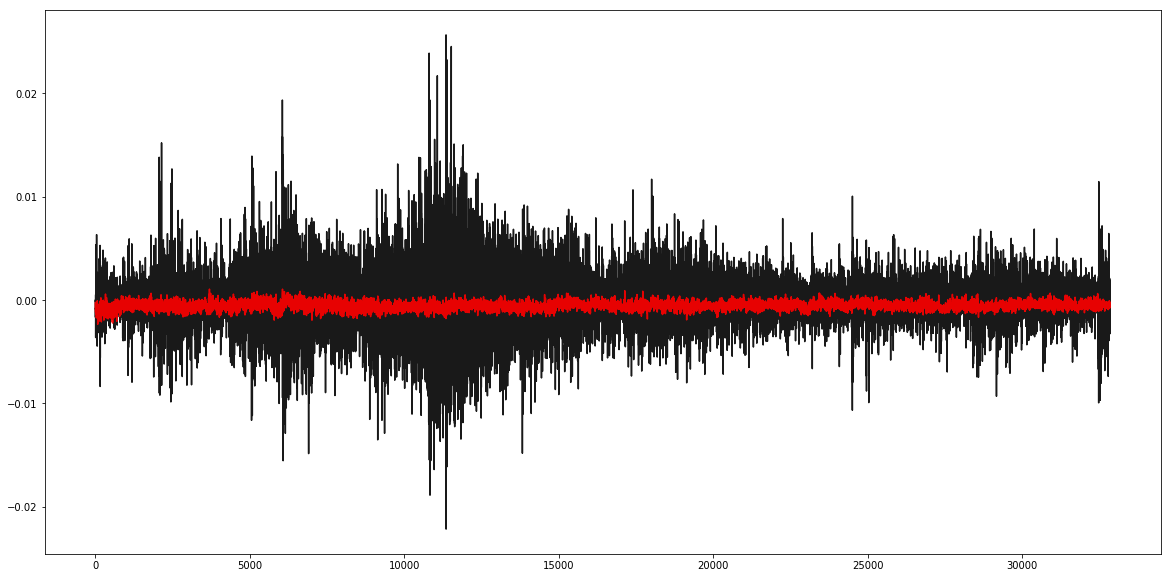

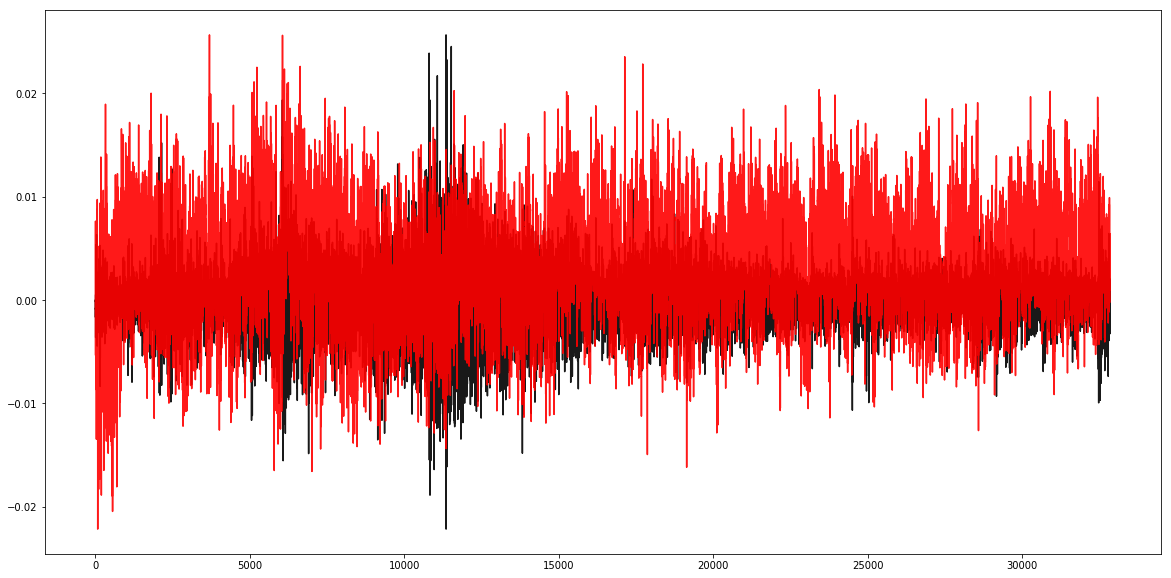

In [70]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

timestep_within_window = 0
minute_start = 59
minute_end = len(Y_test)

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
#print_save_events_props(Y_train, Y_dev, Y_test, evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end)

In [71]:
# MAIN MODEL ##

# HYPERPARAMETERS
window_size = 30
step = 1
predict_end_of_window = False

batch_size = 1024
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
# num_LSTM = 3
# num_units = [128, 256, 256]
num_LSTM = 2
num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), batch_size, num_epochs, 
                                                                                                                                                loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-30_step-1_predEndWindow-False_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592853, 30, 15)
(32909, 30, 15)
(32909, 30, 15)
(592853, 30, 1)
(32909, 30, 1)
(32909, 30, 1)


In [73]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, 
                                         dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                      validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592853 samples, validate on 32909 samples
Epoch 1/30
592853/592853 [==============================] - 63s 107us/step - loss: 7.0941e-04 - val_loss: 6.9629e-06
Epoch 2/30
592853/592853 [==============================] - 63s 106us/step - loss: 5.8370e-06 - val_loss: 6.4146e-06
Epoch 3/30
592853/592853 [==============================] - 63s 106us/step - loss: 3.4445e-06 - val_loss: 5.8623e-06
Epoch 4/30
592853/592853 [==============================] - 63s 106us/step - loss: 2.5623e-06 - val_loss: 5.8137e-06
Epoch 5/30
592853/592853 [==============================] - 64s 107us/step - loss: 2.3067e-06 - val_loss: 6.2616e-06
Epoch 6/30
592853/592853 [==============================] - 64s 108us/step - loss: 2.1014e-06 - val_loss: 6.6544e-06
Epoch 7/30
592853/592853 [==============================] - 64s 109us/step - loss: 2.5926e-06 - val_loss: 8.6082e-06
Epoch 8/30
592853/592853 [==============================] - 65s 109us/step - loss: 2.3447e-06 - val_loss: 7.8667e-06
Epoch 9/30
59

ImportError: `save_weights` requires h5py.

In [80]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-30_step-1_predEndWindow-False_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [4261783 8991609 4532198]
Down, Same, Up: [0.23962    0.50555585 0.25482416]

=== DEV ===
Down, Same, Up: [450604  73018 463648]
Down, Same, Up: [0.45641415 0.0739595  0.46962634]

=== TEST ===
Down, Same, Up: [446216  84298 456756]
Down, Same, Up: [0.45196957 0.08538495 0.46264548]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.256474
DEV:   0.468502
TEST:  0.470619

========== FINAL LOSS ==========
TRAIN: 1.690305185913845e-06
DEV:   5.907358330154416e-06
TEST:  1.690305185913845e-06



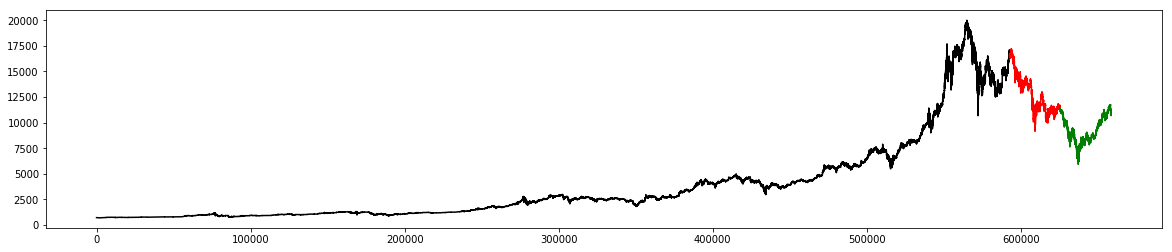

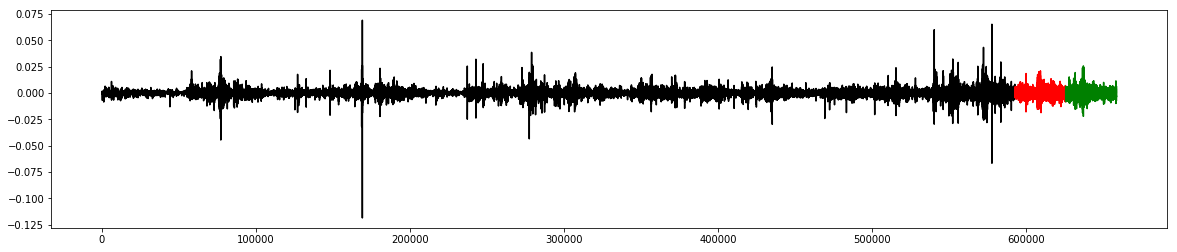

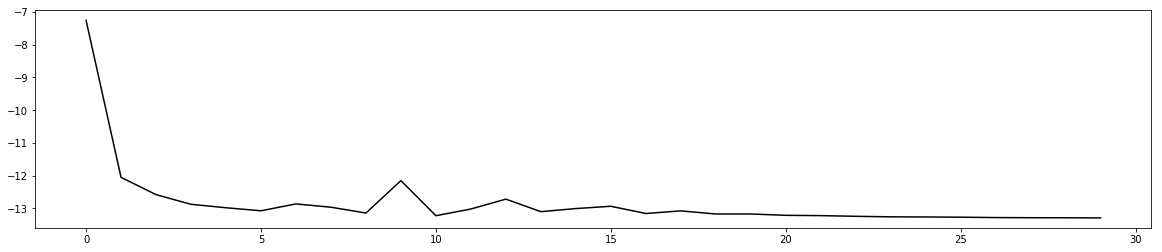

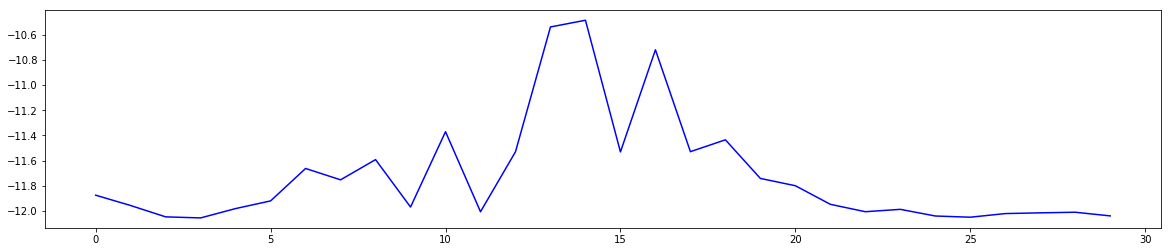

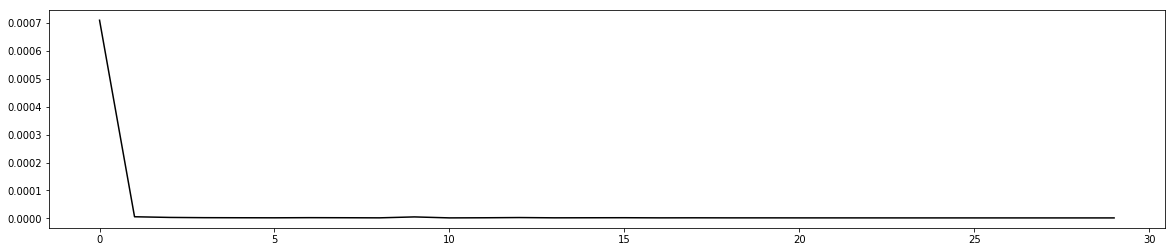

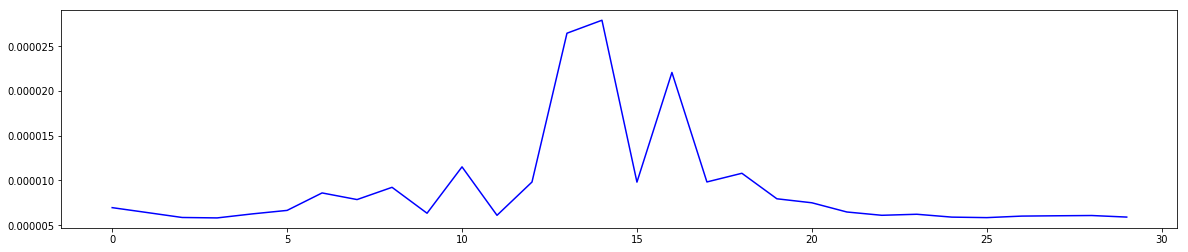

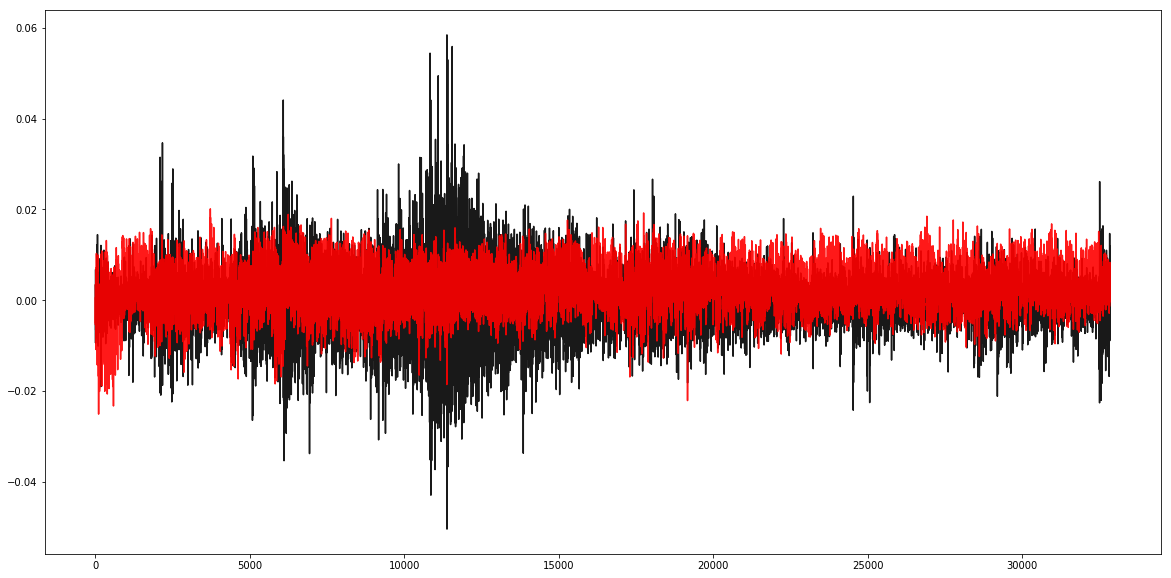

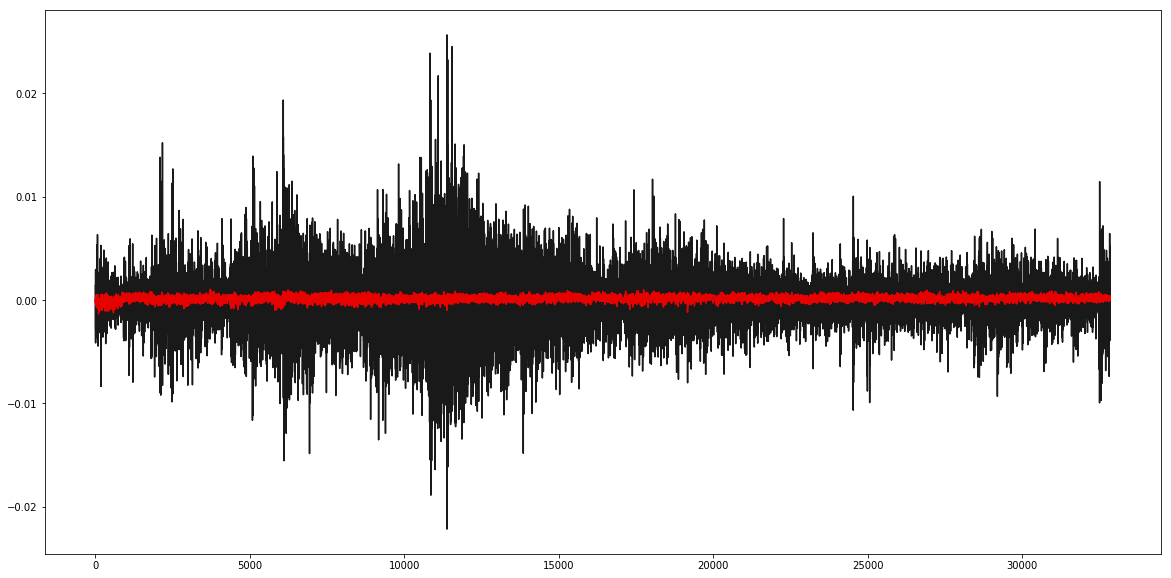

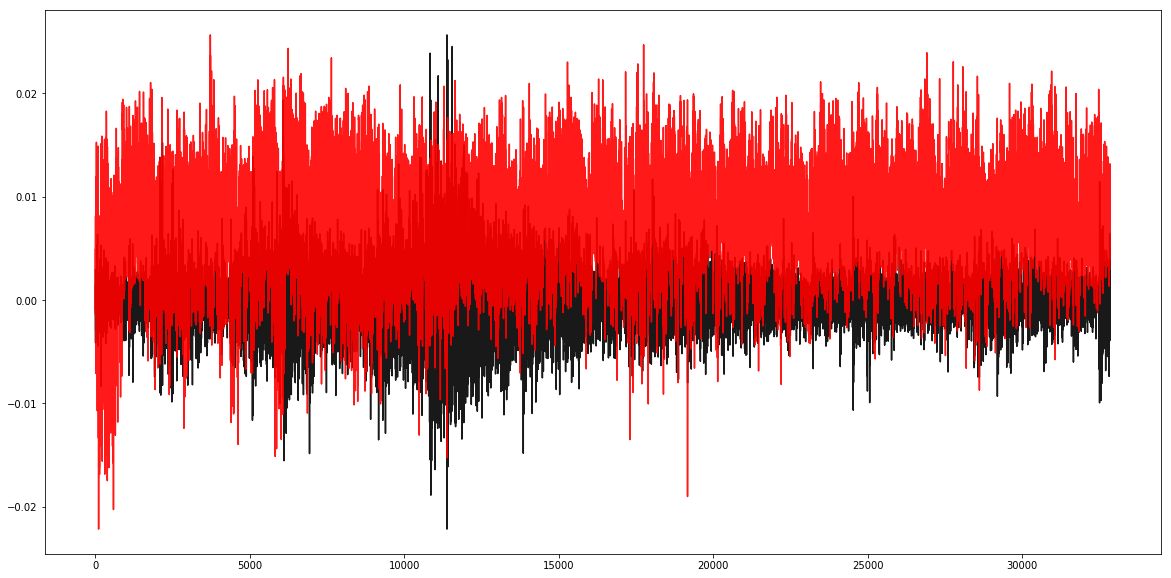

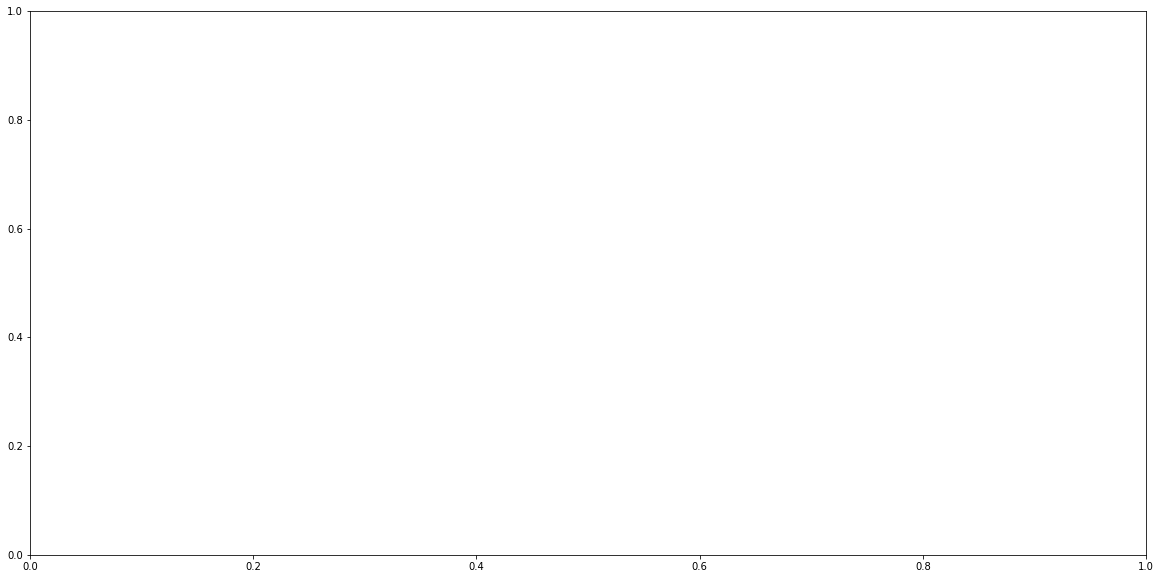

In [82]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

timestep_within_window = 0
minute_start = 59
minute_end = len(Y_test)

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
#print_save_events_props(Y_train, Y_dev, Y_test, evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [28]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 30
step = 1
predict_end_of_window = True
temporal_features = True

batch_size = 1024
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
#num_LSTM = 3
#num_units = [128, 256, 256]
num_LSTM = 2
num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-30_step-1_predEndWindow-True_temporalFeat-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 58)
(32938, 58)
(32938, 58)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592853, 30, 58)
(32909, 30, 58)
(32909, 30, 58)
(592853, 1)
(32909, 1)
(32909, 1)


In [29]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, 
                                         dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                      validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592853 samples, validate on 32909 samples
Epoch 1/30
592853/592853 [==============================] - 65s 109us/step - loss: 0.0015 - val_loss: 1.1038e-05
Epoch 2/30
592853/592853 [==============================] - 63s 107us/step - loss: 2.3936e-05 - val_loss: 7.8309e-06
Epoch 3/30
592853/592853 [==============================] - 64s 107us/step - loss: 3.8483e-05 - val_loss: 1.4738e-05
Epoch 4/30
592853/592853 [==============================] - 64s 108us/step - loss: 1.9852e-05 - val_loss: 3.9325e-05
Epoch 5/30
592853/592853 [==============================] - 65s 109us/step - loss: 3.0536e-05 - val_loss: 1.3085e-05
Epoch 6/30
592853/592853 [==============================] - 65s 109us/step - loss: 2.7753e-05 - val_loss: 3.1634e-04
Epoch 7/30
592853/592853 [==============================] - 65s 110us/step - loss: 2.8969e-04 - val_loss: 5.9049e-06
Epoch 8/30
592853/592853 [==============================] - 65s 110us/step - loss: 2.3753e-06 - val_loss: 5.8298e-06
Epoch 9/30
592853

ImportError: `save_weights` requires h5py.

In [30]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-30_step-1_predEndWindow-True_temporalFeat-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [142066 299707 151080]
Down, Same, Up: [0.23963107 0.50553341 0.25483552]

=== DEV ===
Down, Same, Up: [15019  2434 15456]
Down, Same, Up: [0.45637971 0.07396153 0.46965876]

=== TEST ===
Down, Same, Up: [14874  2809 15226]
Down, Same, Up: [0.45197362 0.08535659 0.46266979]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.240704
DEV:   0.456380
TEST:  0.453250

========== FINAL LOSS ==========
TRAIN: 1.8221042200068918e-06
DEV:   1.006802252977258e-05
TEST:  1.8221042200068918e-06



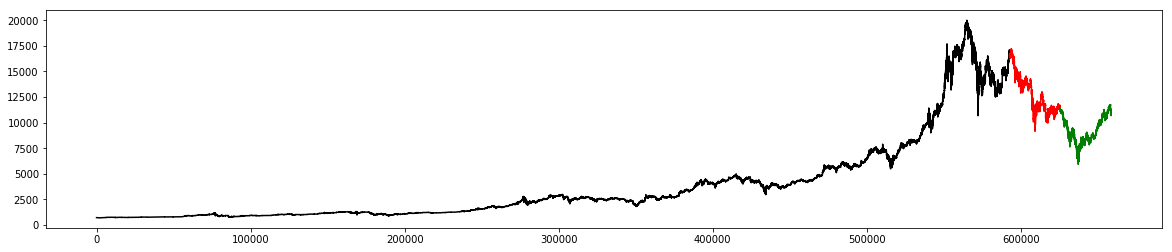

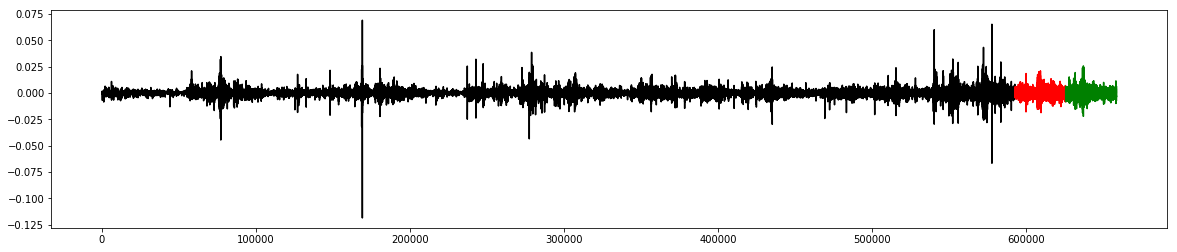

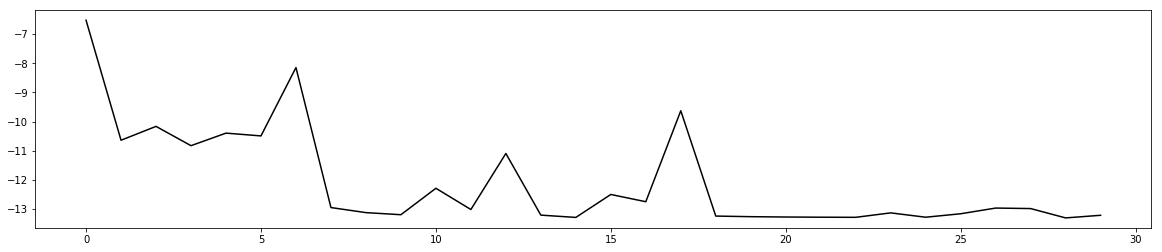

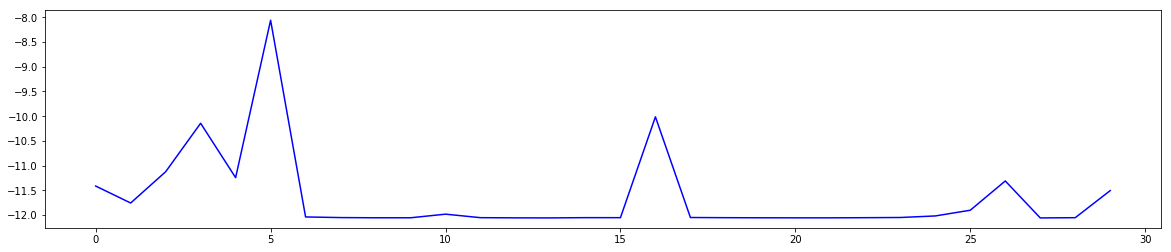

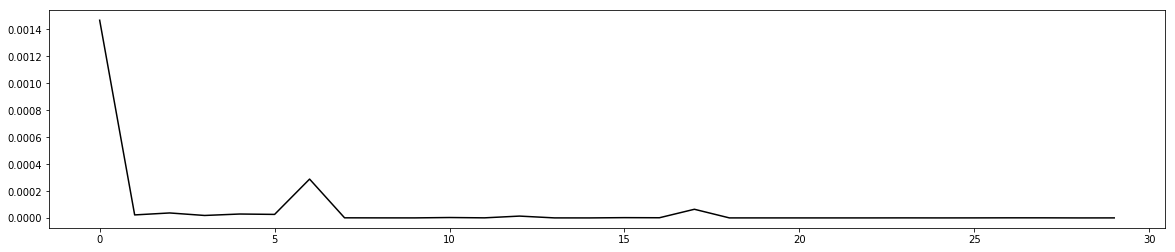

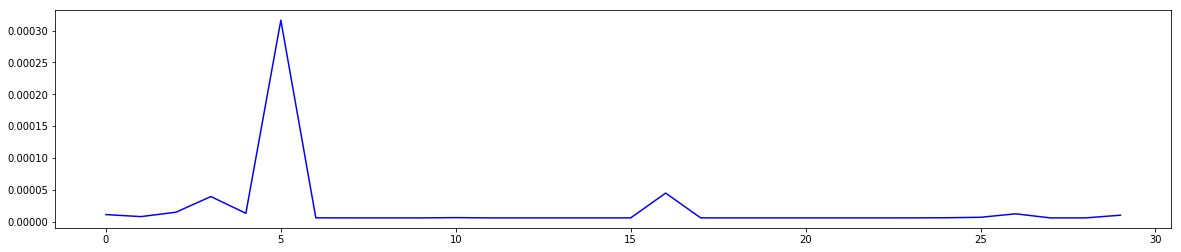

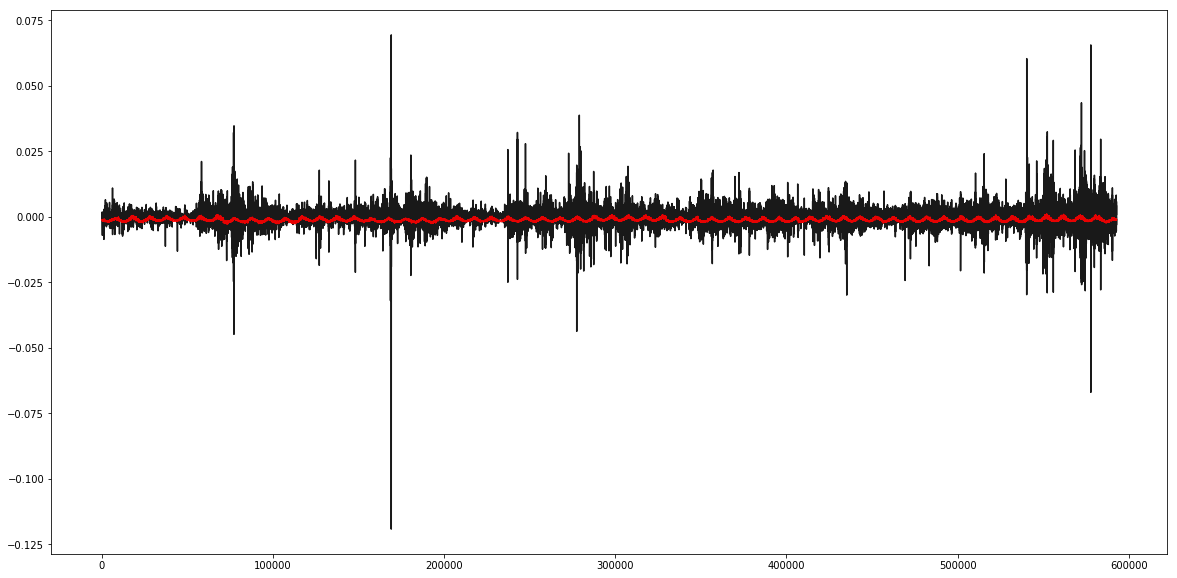

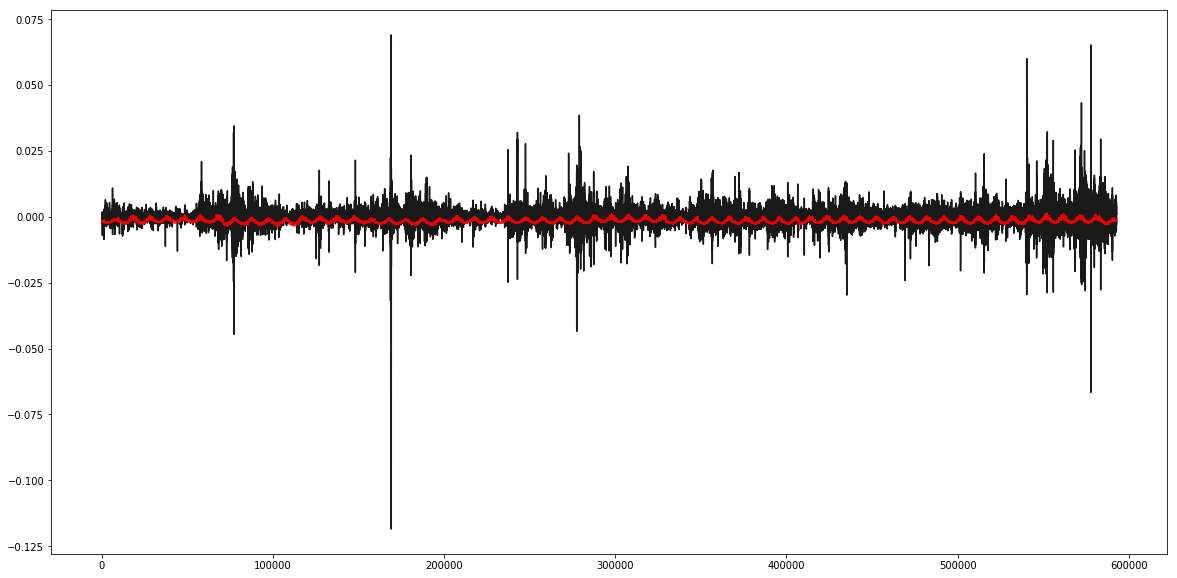

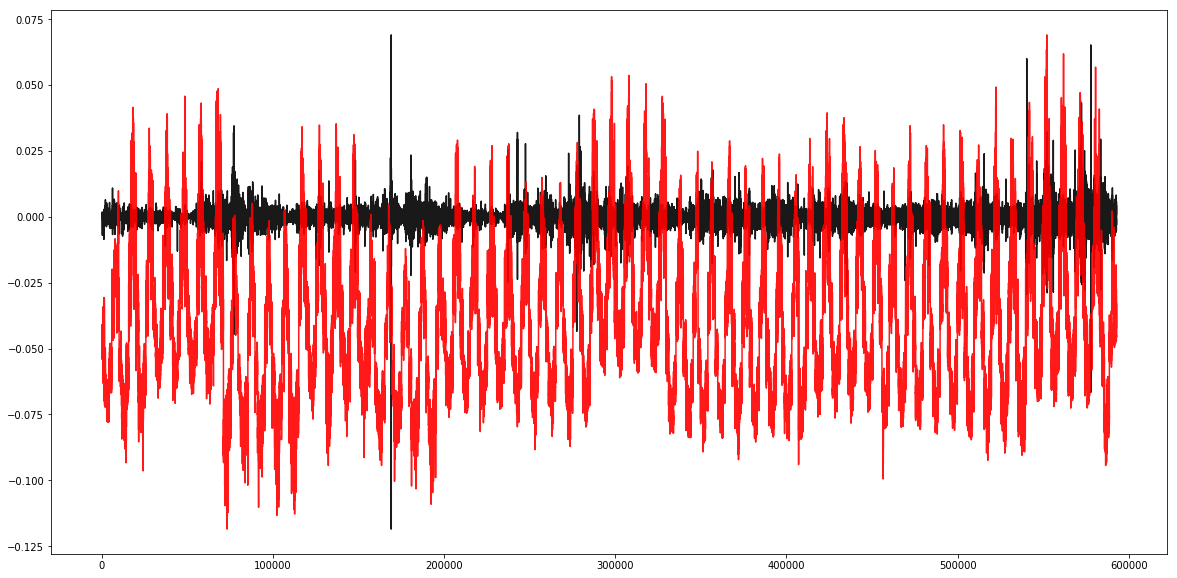

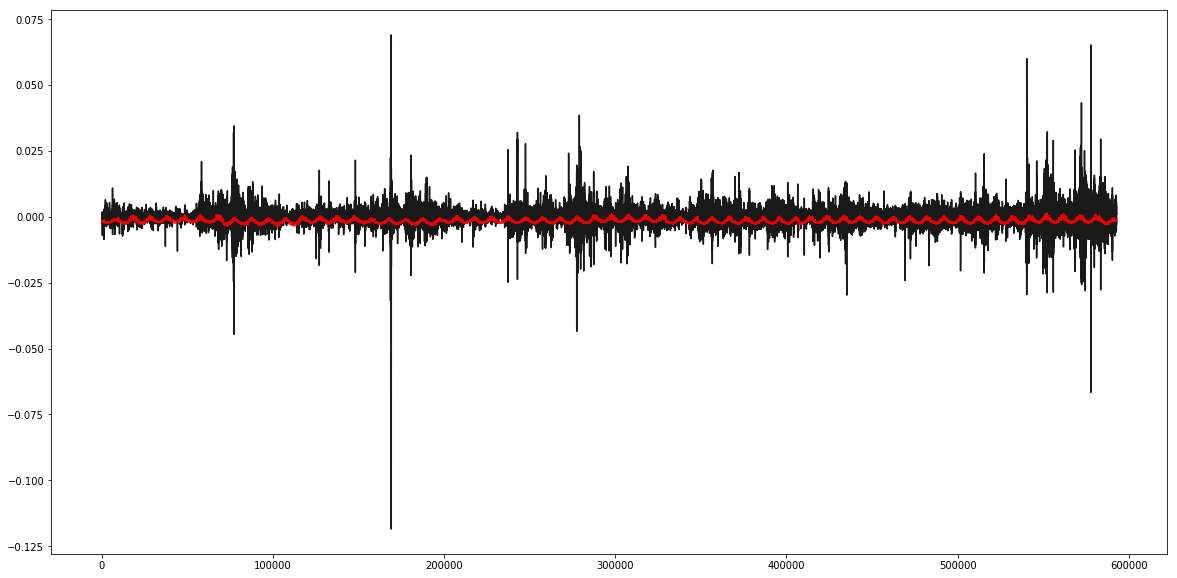

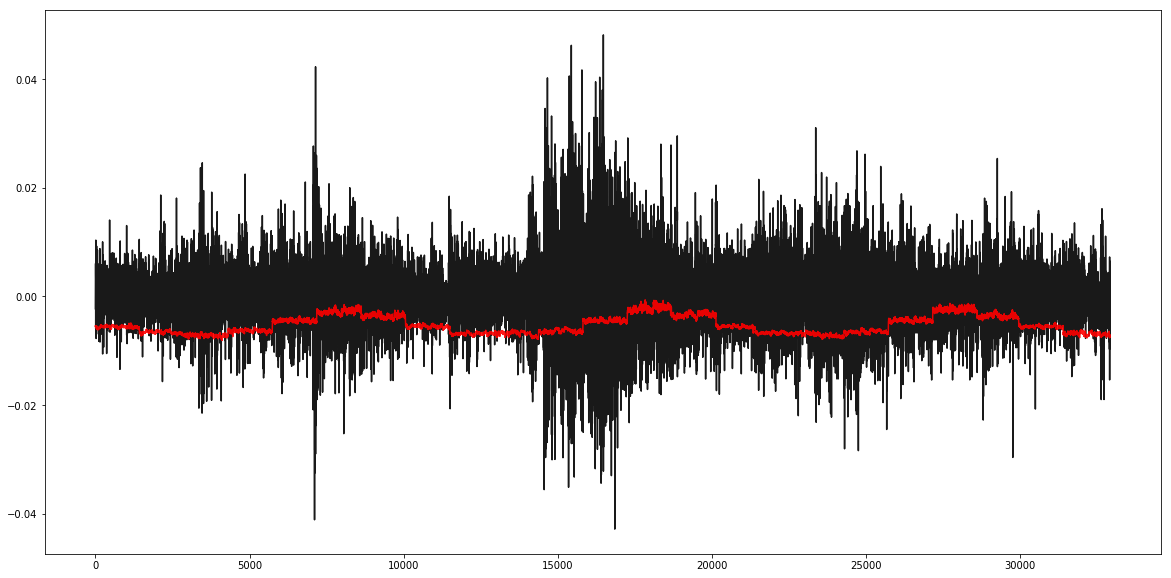

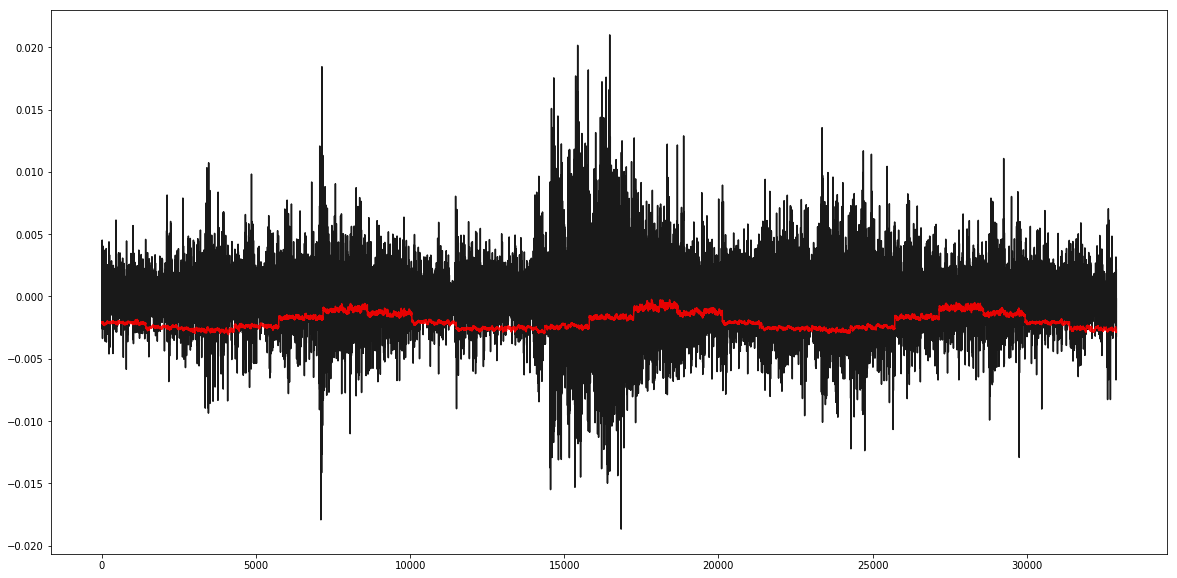

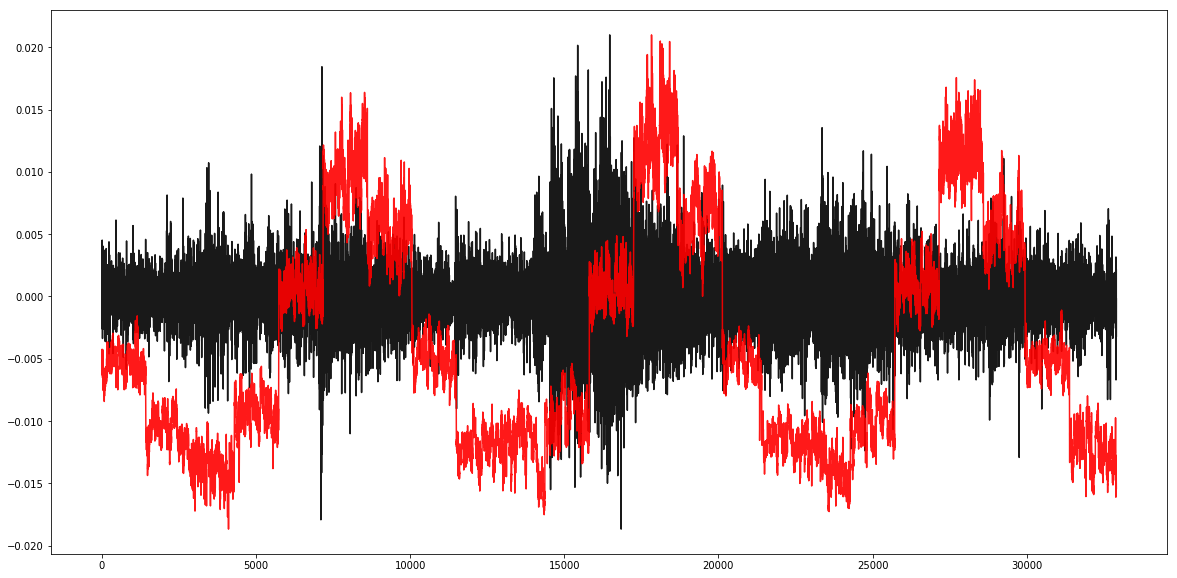

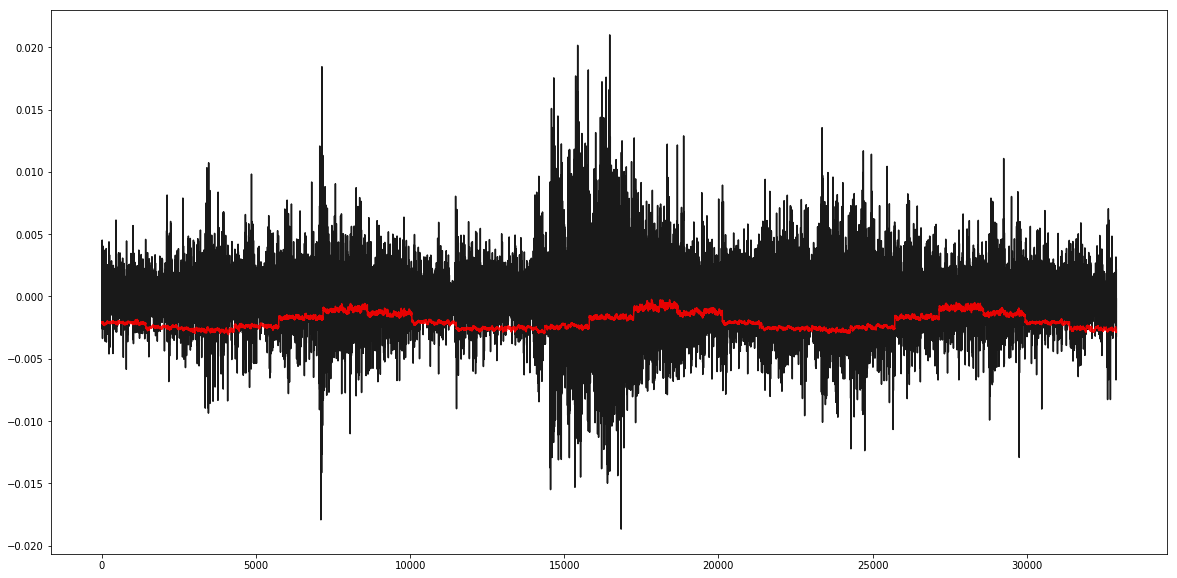

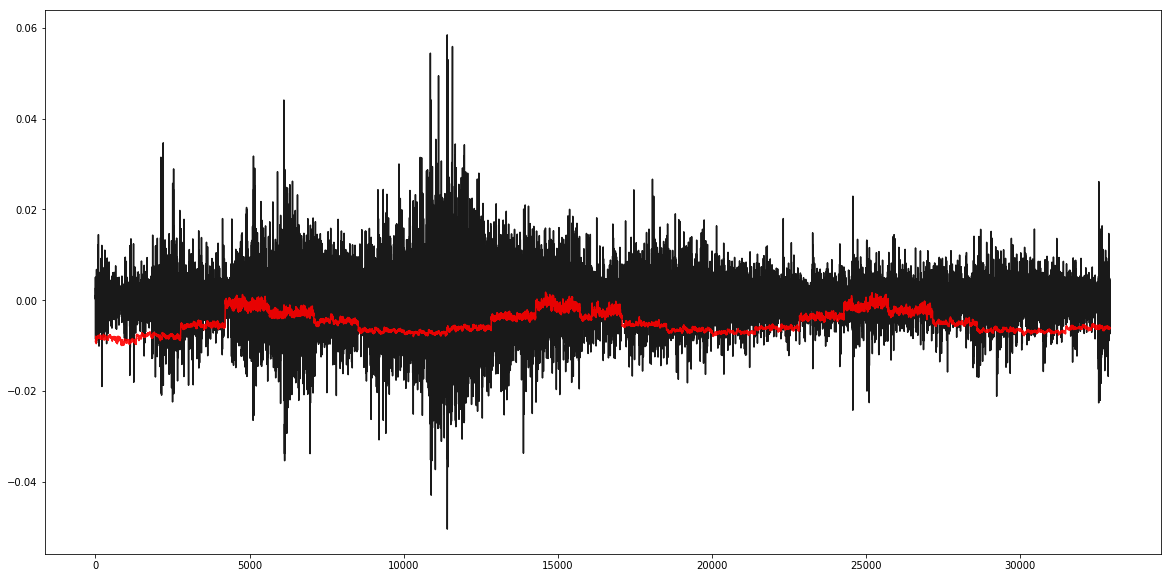

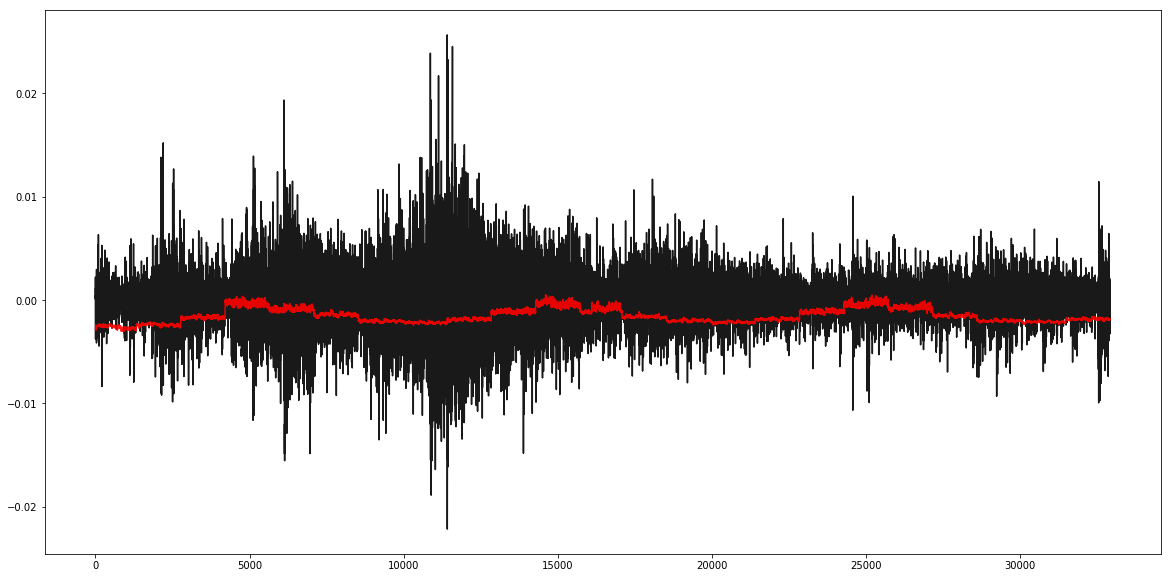

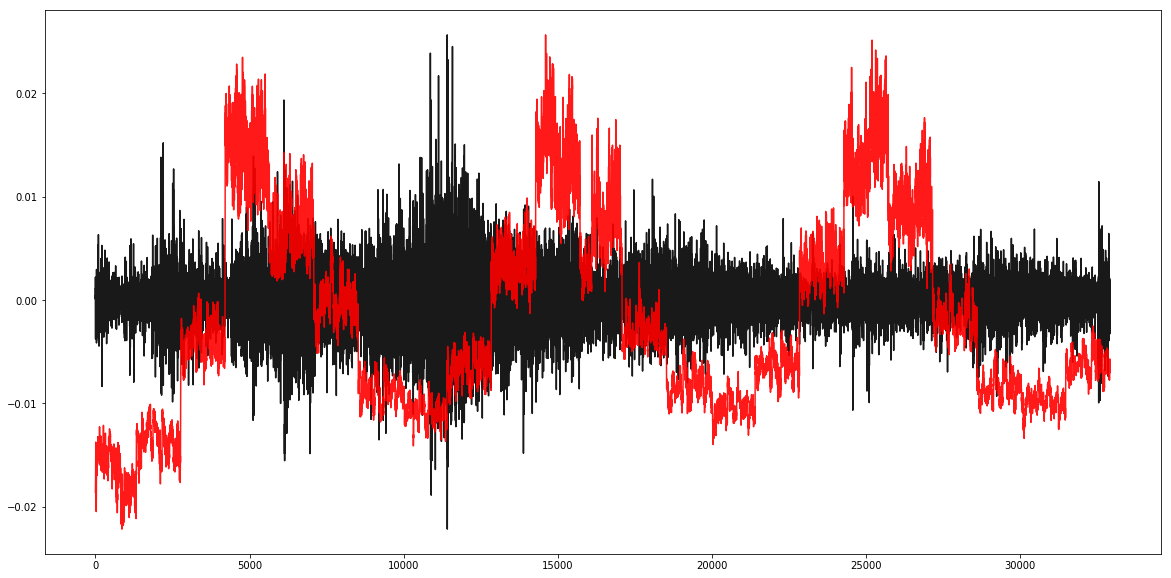

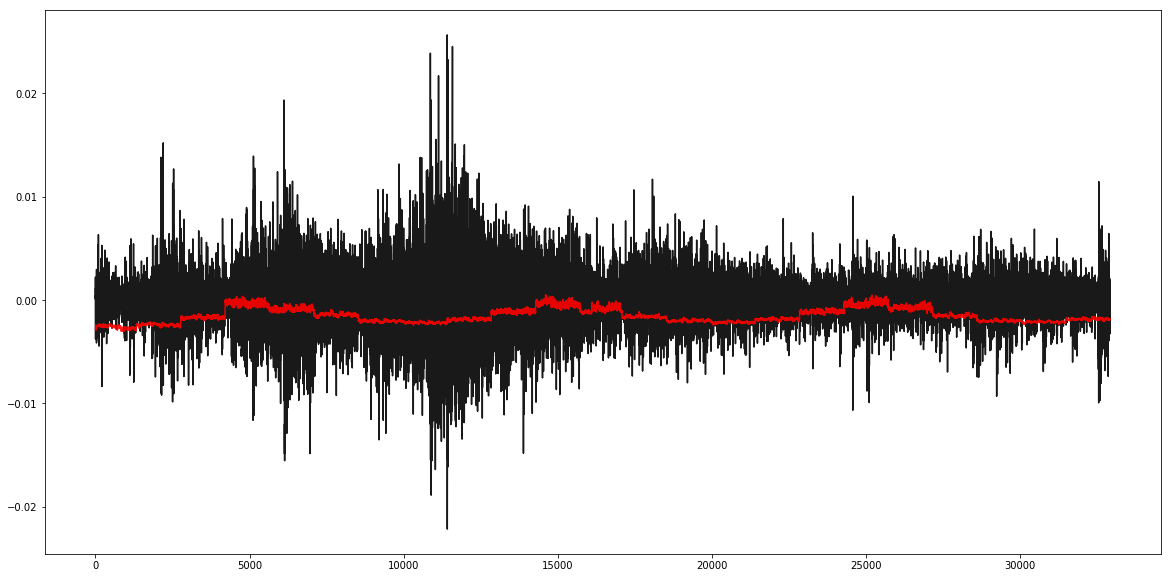

In [32]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
  timestep_within_window = 0
else:
  timestep_within_window = 29
  
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [28]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 30
step = 1
predict_end_of_window = False
temporal_features = True

batch_size = 1024
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
#num_LSTM = 3
#num_units = [128, 256, 256]
num_LSTM = 2
num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-30_step-1_predEndWindow-False_temporalFeat-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 58)
(32938, 58)
(32938, 58)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592853, 30, 58)
(32909, 30, 58)
(32909, 30, 58)
(592853, 30, 1)
(32909, 30, 1)
(32909, 30, 1)


In [29]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, 
                                         dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                      validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592853 samples, validate on 32909 samples
Epoch 1/30
592853/592853 [==============================] - 66s 112us/step - loss: 9.6823e-04 - val_loss: 2.0219e-05
Epoch 2/30
592853/592853 [==============================] - 66s 111us/step - loss: 2.4366e-05 - val_loss: 2.9772e-05
Epoch 3/30
592853/592853 [==============================] - 66s 112us/step - loss: 3.2134e-05 - val_loss: 7.3149e-06
Epoch 4/30
592853/592853 [==============================] - 67s 113us/step - loss: 2.8019e-05 - val_loss: 1.0122e-04
Epoch 5/30
592853/592853 [==============================] - 67s 114us/step - loss: 4.2348e-05 - val_loss: 5.9235e-06
Epoch 6/30
592853/592853 [==============================] - 69s 116us/step - loss: 2.4616e-06 - val_loss: 5.8401e-06
Epoch 7/30
592853/592853 [==============================] - 68s 114us/step - loss: 1.5573e-05 - val_loss: 5.9720e-06
Epoch 8/30
592853/592853 [==============================] - 68s 115us/step - loss: 1.9849e-06 - val_loss: 6.5064e-06
Epoch 9/30
59

ImportError: `save_weights` requires h5py.

In [31]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-30_step-1_predEndWindow-False_temporalFeat-True_batch-1024_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [4261783 8991609 4532198]
Down, Same, Up: [0.23962    0.50555585 0.25482416]

=== DEV ===
Down, Same, Up: [450604  73018 463648]
Down, Same, Up: [0.45641415 0.0739595  0.46962634]

=== TEST ===
Down, Same, Up: [446216  84298 456756]
Down, Same, Up: [0.45196957 0.08538495 0.46264548]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.250652
DEV:   0.465444
TEST:  0.458726

========== FINAL LOSS ==========
TRAIN: 1.6735324575415412e-06
DEV:   5.79123411475295e-06
TEST:  5.8658116147463426e-06



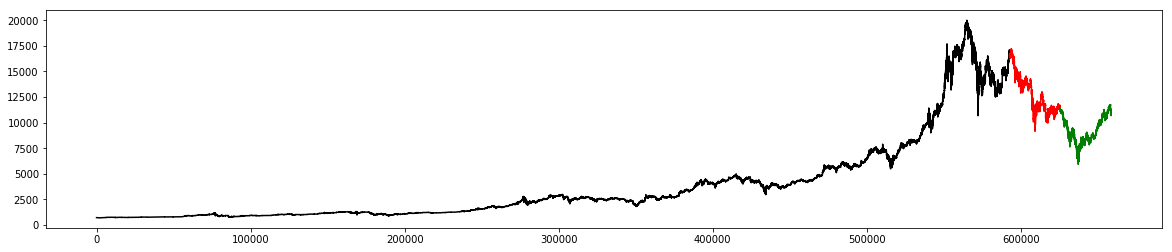

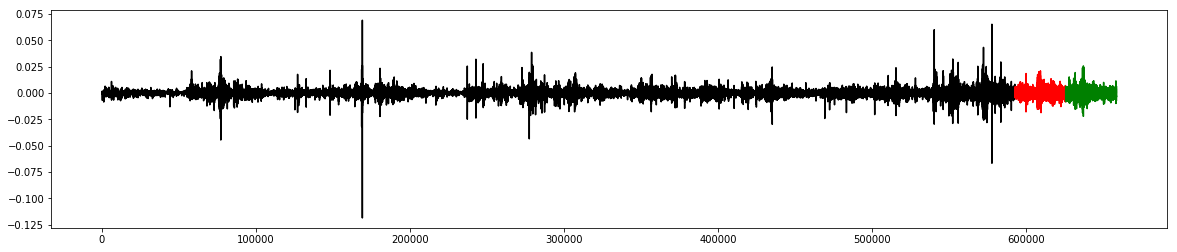

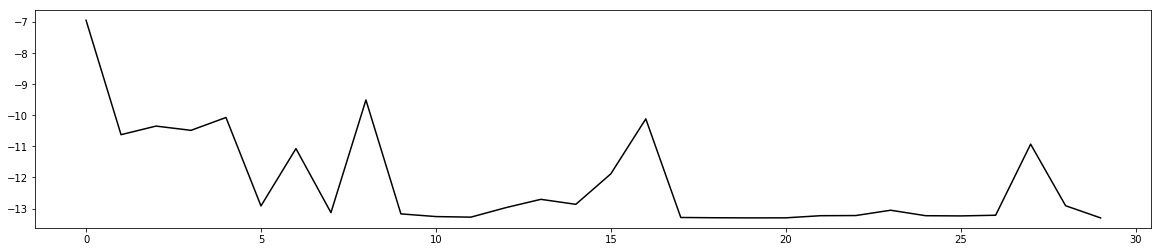

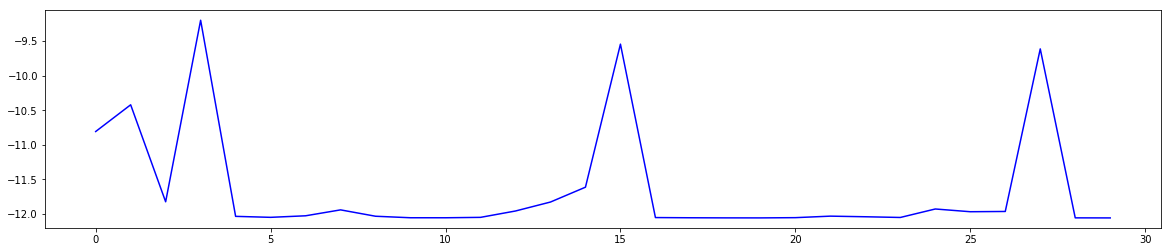

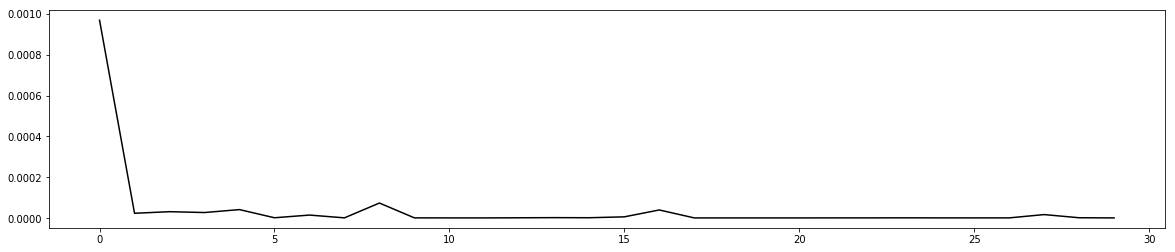

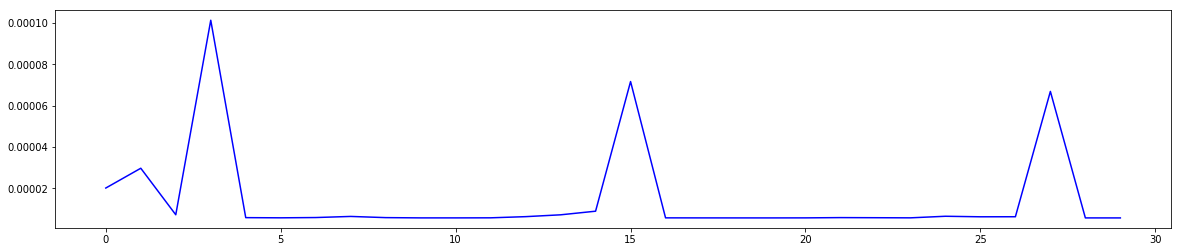

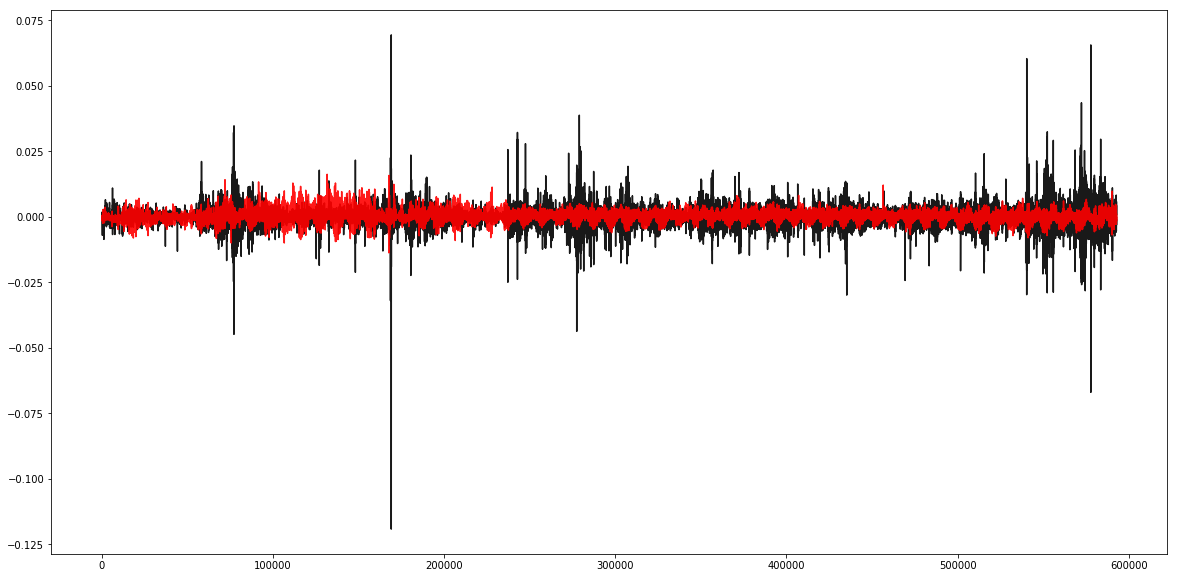

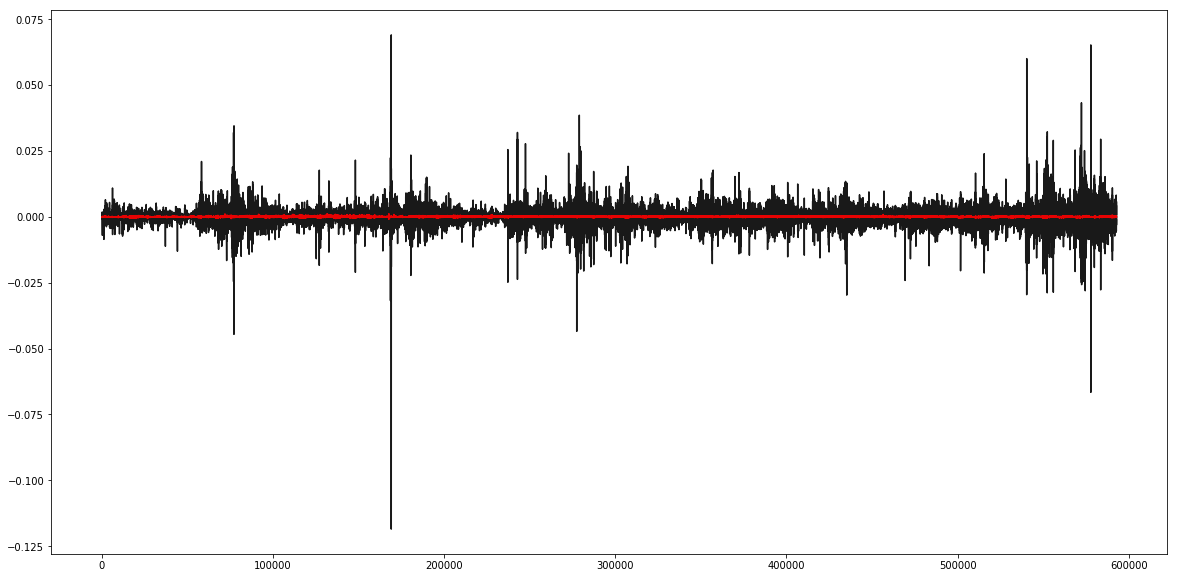

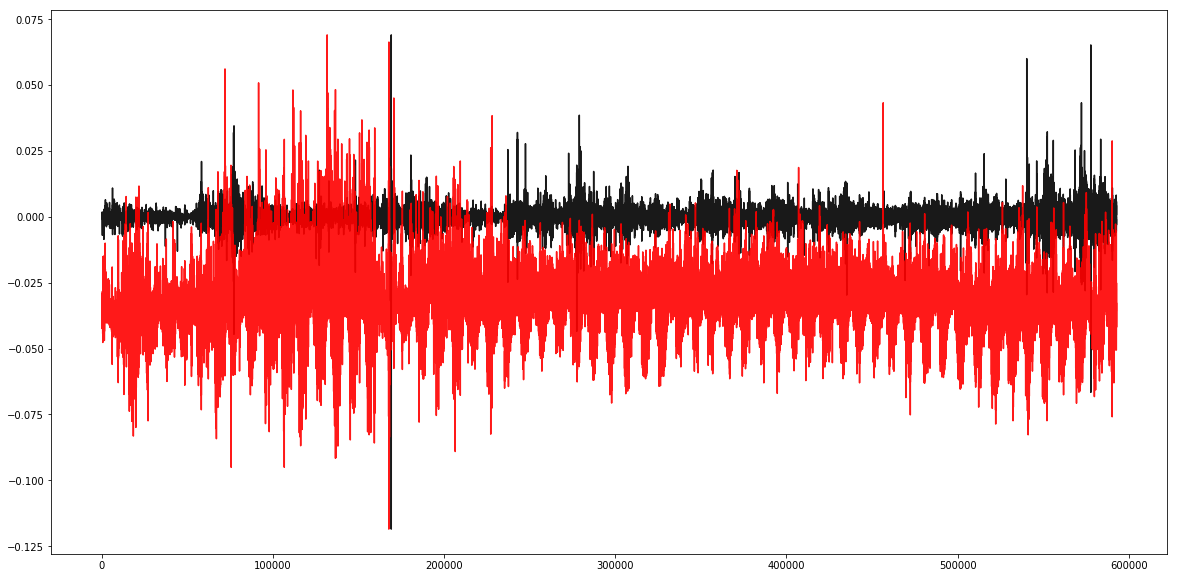

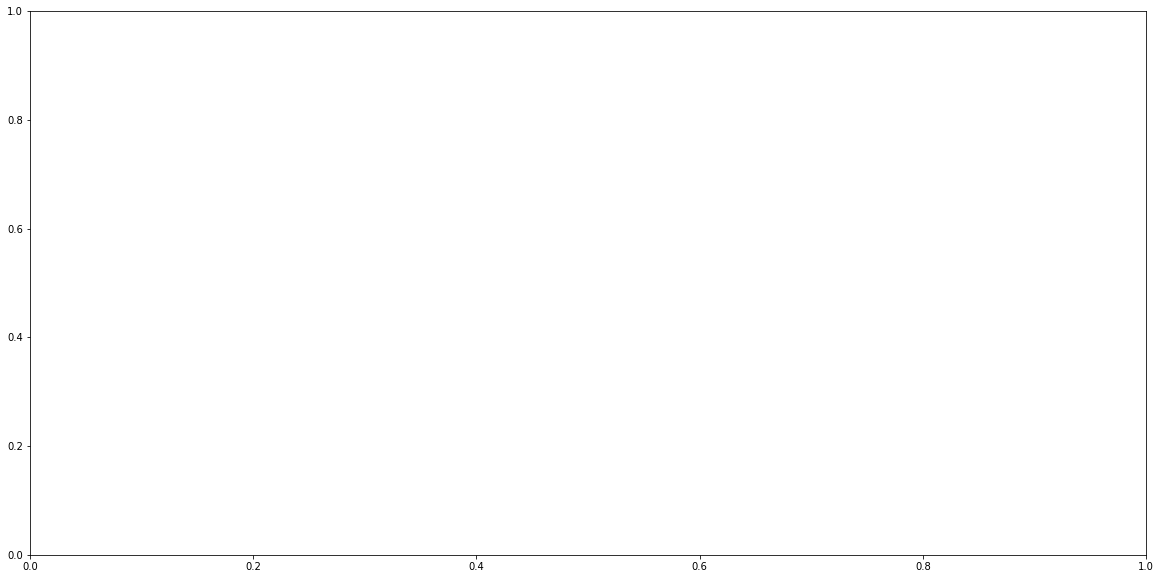

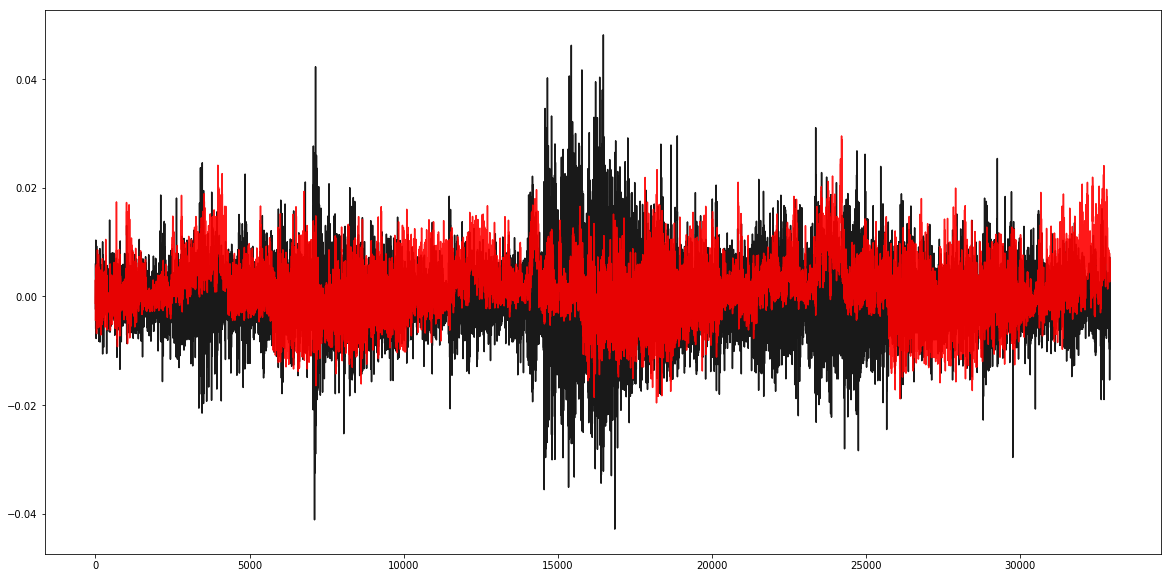

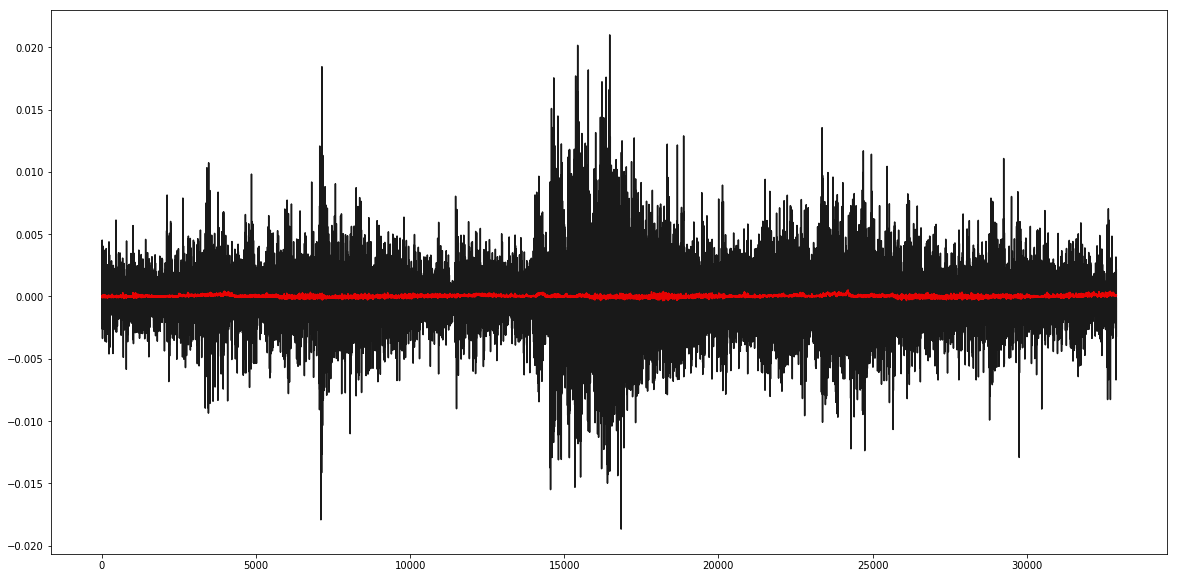

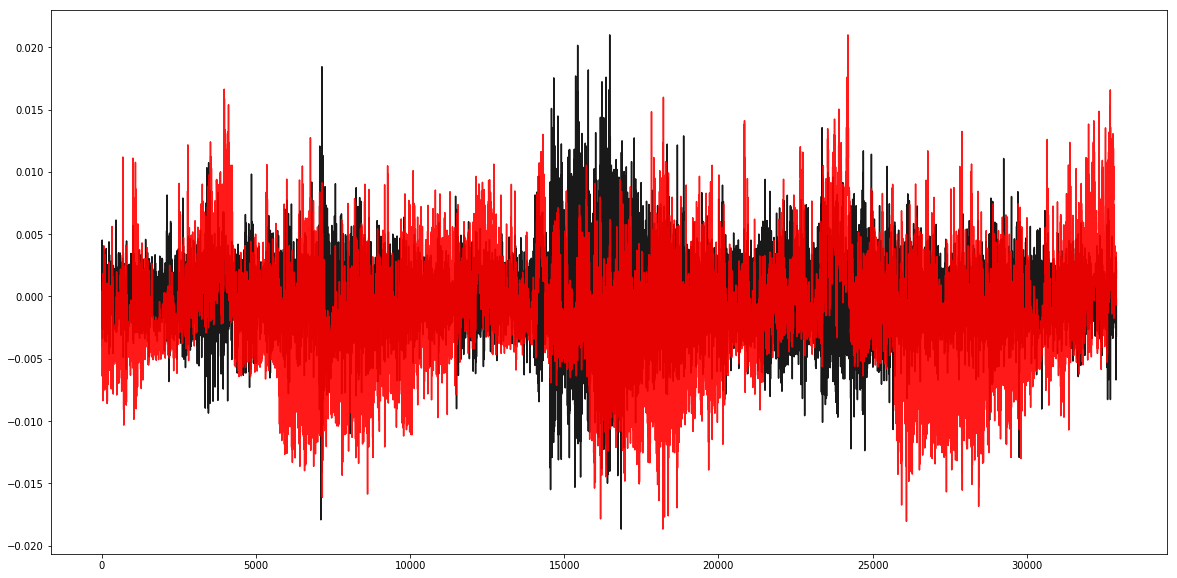

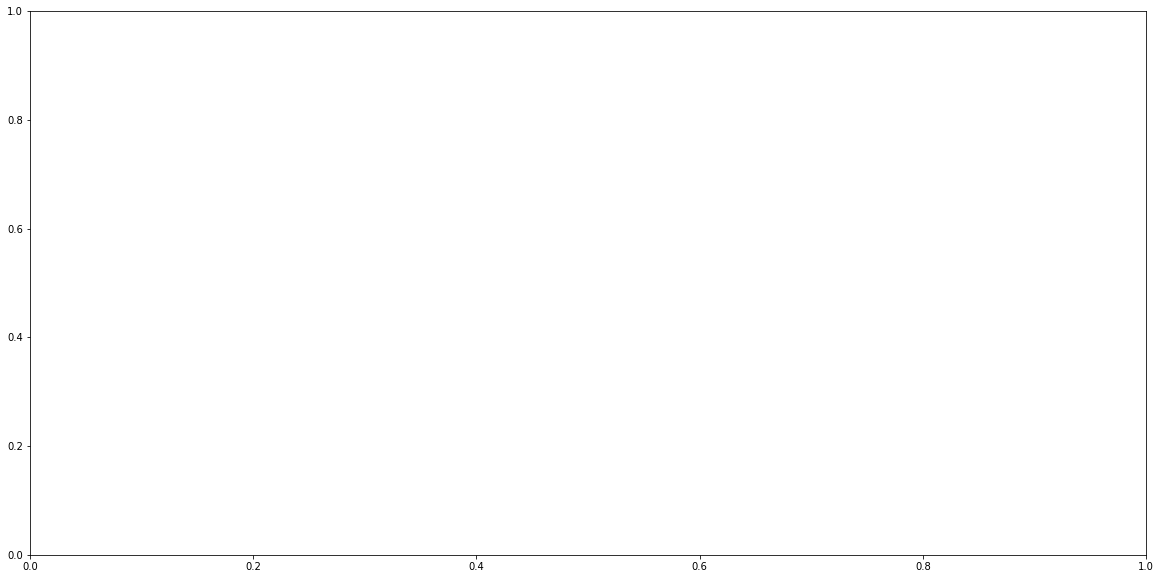

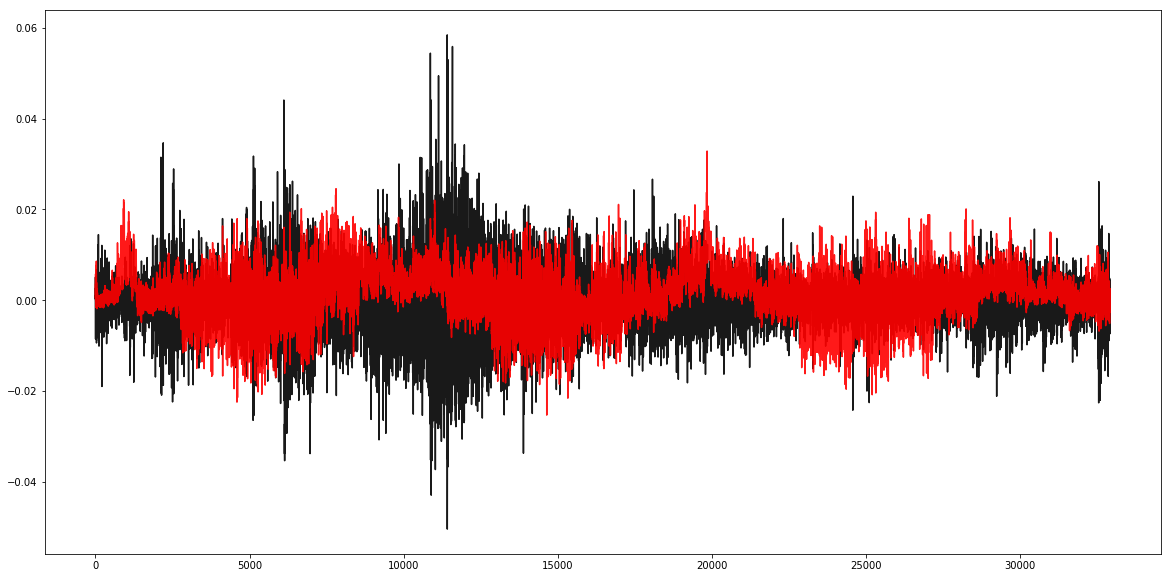

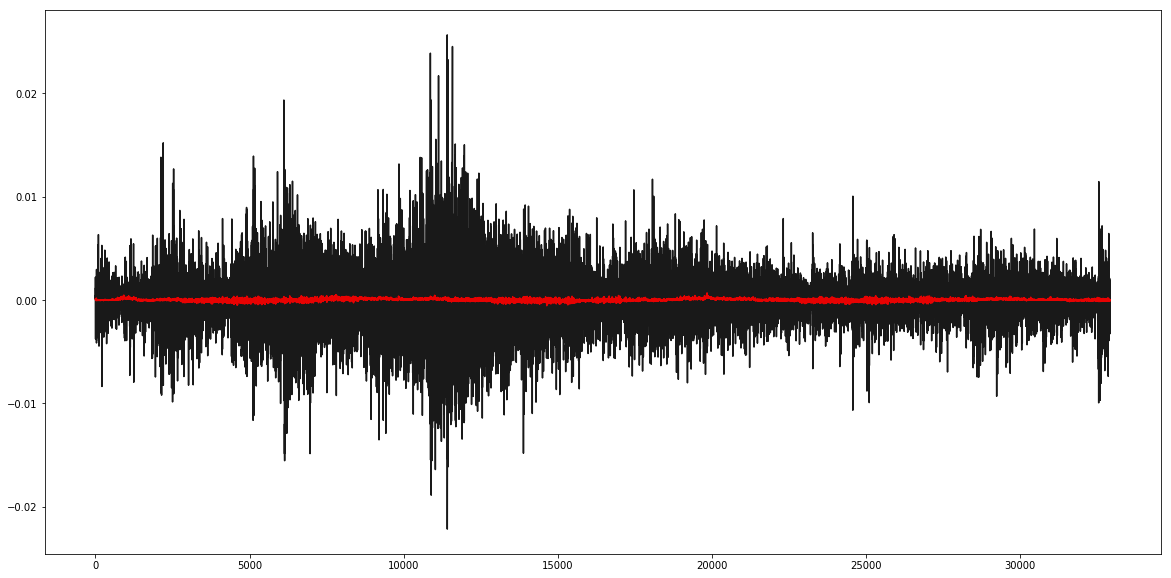

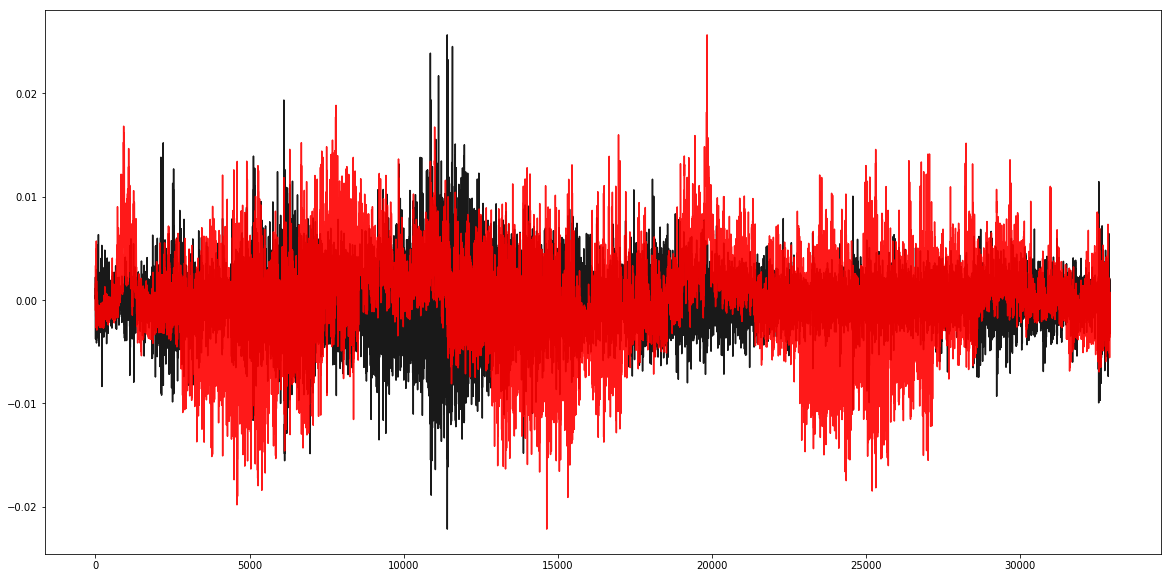

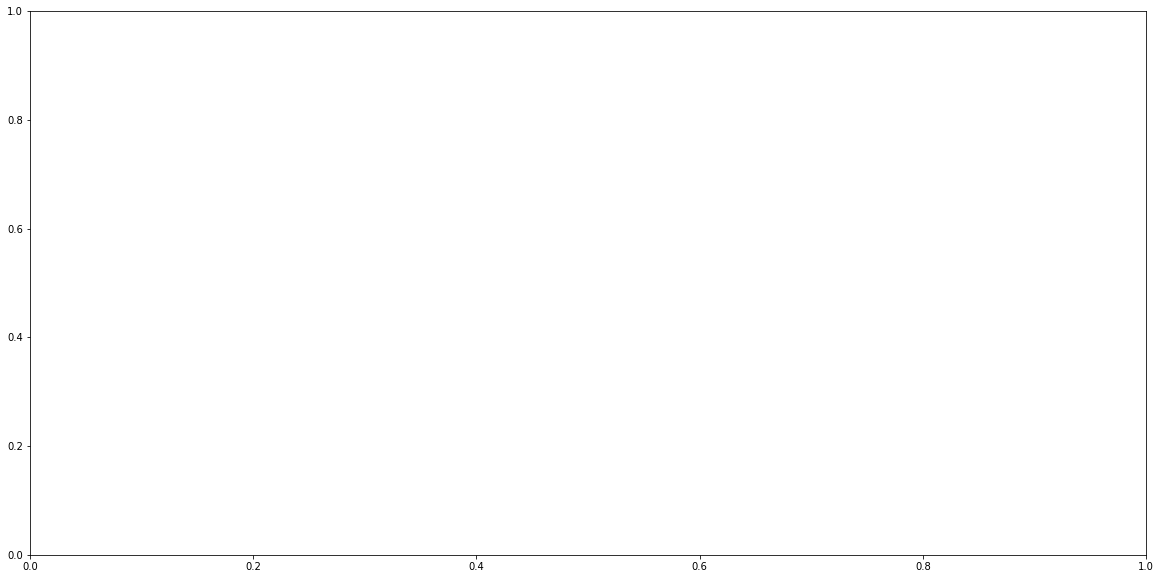

In [32]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
  timestep_within_window = 0
else:
  timestep_within_window = 29
  
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)